## Aquifer Auser

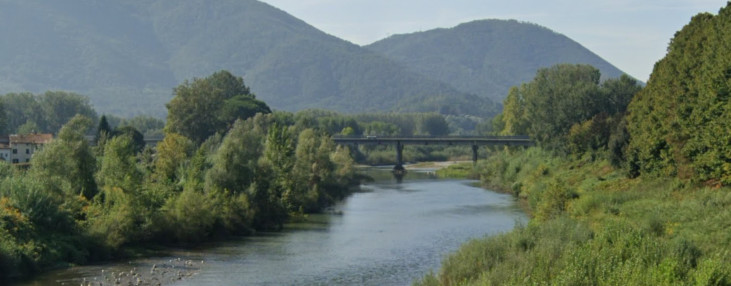

### [Introduction](#int)
### [Methodology](#method)
### [Global Imports](#gi)
### [Data](#data)
### [Custom functions and lists](#custom)
### [Statistical summary](#stat)
### [Imputation of missing values](#imp)
### [Descriptive data analysis](#analysis)
### [Feature engineering](#features)
### [SARIMAX](#sarimax)
### [LSTM](#lstm)
### [Comparison of results](#comparison)
### [References to works used in this project](#ref)

### Introduction <a class='anchor' id='int'></a>

The objective of this study is to analyse impact of meteorological variables and extraction on the fluctation of groundwater level in Auser Aquifer, and derive data-driven model to forecast temporal variation of GWL one day (LSTM) and 30 days (SARIMAX) ahead. 

Two models are developed:

 - SARIMAX (seasonal ARIMA with exogenous inputs) and 
 - Deep learning RNN LSTM model.

The project is concluded with comparing forecasting accuracy (in-sample) and  R2 scores for both models.

We have data on three observation wells for Auser aquifer, one LT2 in confined zone and two SAL & CoS in unconfined zones. Due to the physical differences (outlined below) between types of aquifers, modeling parameters shall be optimized for each well/target outcome.

**Understanding groundwater level trend in aquifers**

Aquifer is a geological formation that is capable of yielding sufficient quantities of water to wells. Ground water occupies the openings in earth materials such as intergranular pores in sands and gravels or cracks or cavities in otherwise solid rock. Porosity and permeability of a given rock or sediment are two primary factors determining quantity of aquifer water yield. ("A historical summary on ground water levels and trends, division of waters Minnesota DNR, June 1989").

It is well established in hydrology science that groundwater levels in aquifers fluctate in the long and short terms, primarily in response to changes in precipitation and extraction/pumping. Studies also show that modeling of a particular aquifer is not generalizable and subject to local geological and environmental conditions. 

**Confined aquifer, observation well LT2**

Confined aquifers are bounded at the top by relatively impermeable formations. The level to which water
will rise in a well in a confined aquifer is termed the potentiometric surface. Water level fluctuations in confined observation wells tend to occur more rapidly and changes are much larger. Recharge to the confined aquifer occurs primarily in the upland area where the confining layer is not present and to a lesser extent through slow downward leakage through the confining layer.


**Unconfined aquifer, observation well SAL and CoS**

Unconfined aquifers generally are close to the land surface and are exposed to the atmosphere through pores in the overlying formation. The upper surface of the saturated zone in this aquifer is called the water table. The unconfined aquifer, having only permeable unsaturated material above it, is recharged relatively quickly as water infiltrates into the ground.

### Methodology <a class='anchor' id='method'></a>

**SARIMAX**

SARIMAX is an extention of the stochastic time series ARIMA models, which are often used for medium-range forecasting.

SARIMAX models are denoted SARIMA(p,d,q)(P,D,Q)[S], where S refers to the number of periods in each season, d is the degree of differencing, and the uppercase P, D, and Q refer to the autoregressive, differencing, and moving average terms for the seasonal part of the ARIMA model. X stands for exogenous variables.

Two variants are constructed to forecast groundwater level: SARIMA trained on lagged values of target variable and SARIMAX trained on lagged values of target variable and selected exogenous regressors.

Workflow for both models consists of the following steps:

- Estimate order of differencing 'd' (seasonal decomposition, ADF/KSS tests) to correct for stationarity
- Estimate autoregressive and moving averages 'p' and 'q' (ACF/PACF on differenced series) for smoothing series
- Estimate seasonality and P, Q terms
- Train model with estimated parameters
- Validate model on test data, evaluate diagnostics and tune
- Add exogenous regressors and repeat the above steps
- Select model with the best forecasting accuracy
- Demonstrate forecast of groundwater level 30 days ahead for each observation well.


**LSTM**

Long Short-Term Memory (LSTM) network, a special type of recurrent neural network.

LSTM networks are well-suited to classifying, processing and making predictions based on time series data, since there can be lags of unknown duration between important events in a time series (Source - wikipedia). 

Although length/amount of the data available in this study might not be sufficient for deep learning approach, I will assess its potential in forecasting one day ahead change in the groundwater level. In contrast to the SARIMAX models, target variables will be used only for training the model and will not be required as the input for actual forecast. For each observation well LSTM model will output the Change from the previous date.

Diagram shows simple architecture for LT2 LSTM model with input sequence of 30 (days), 16 input features and batch size(None, selected when running the code), and 1 (day) output.

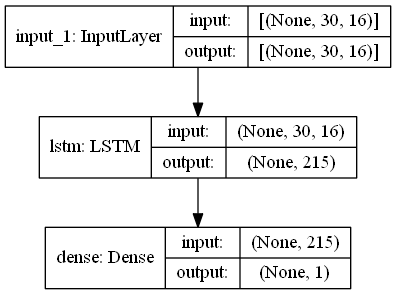

### Global Imports <a class='anchor' id='gi'></a>

In [ ]:
!pip install pymannkendall
!pip install pyhomogeneity
!pip install pmdarima

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import os
import datetime
import math
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
import seaborn as sns

# stats and tests
import pymannkendall as mk
import pyhomogeneity as hg
from scipy import stats

# for imputation of missing values
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor


# for SARIMAX modeling
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm
from statsmodels.tools.eval_measures import mse,rmse
from pmdarima.arima import ndiffs

# for LSTM
from sklearn.preprocessing import MinMaxScaler
import keras as ks
import kerastuner
from kerastuner.tuners import BayesianOptimization
from kerastuner import Objective

### Data <a class='anchor' id='data'></a>

In [ ]:
auser = pd.read_csv('../input/acea-water-prediction/Aquifer_Auser.csv',
                    parse_dates = ['Date'],
                    low_memory=False,
                    index_col = ['Date'])

auser = auser.sort_index()
print(f'Data loaded for Aquifer Auser\n start date: {auser.index.min()}\n end date  : {auser.index.max()}\n')
print('================================================================')
print('')

print('Many missing values at the beginning of series.\n')
print('Will trim original dataset to begin on 1st not null value of the target variable LT2.\n')
start_date = auser[auser['Depth_to_Groundwater_LT2'].notnull()]\
                        ['Depth_to_Groundwater_LT2'].index.min()

auser = auser[auser.index>=start_date].copy()
print('Aquifer Auser dataset revised start date: ', start_date)
print('')
print('Auser dataset shape: ', auser.shape)
print('================================================================')

### Custom functions and lists <a class='anchor' id='custom'></a>

In [ ]:
# Group variable names into custom lists
targets = ['Depth_to_Groundwater_LT2',
           'Depth_to_Groundwater_SAL',
           'Depth_to_Groundwater_CoS']

other_wells = ['Depth_to_Groundwater_PAG', 
               'Depth_to_Groundwater_DIEC']

# List of variables - Railnfall
rainfall = ['Rainfall_Gallicano', 
            'Rainfall_Pontetetto', 
            'Rainfall_Monte_Serra', 
            'Rainfall_Orentano',
            'Rainfall_Borgo_a_Mozzano', 
            'Rainfall_Piaggione', 
            'Rainfall_Calavorno', 
            'Rainfall_Croce_Arcana', 
            'Rainfall_Tereglio_Coreglia_Antelminelli', 
            'Rainfall_Fabbriche_di_Vallico']

# List of variables - Temperature
temp = ['Temperature_Orentano',
        'Temperature_Monte_Serra', 
        'Temperature_Ponte_a_Moriano', 
        'Temperature_Lucca_Orto_Botanico']

# List of variables - Extaction Volumes
vol = ['Volume_POL', 
       'Volume_CC1', 
       'Volume_CC2', 
       'Volume_CSA', 
       'Volume_CSAL']

# List if variables - Hydrometry
hyd = ['Hydrometry_Monte_S_Quirico',
      'Hydrometry_Piaggione']

#================================================================

# Custom names for plots and sections

target1 = 'South sector confined aquifer LT2 well'
target2 = 'North sector unconfined aquifer SAL well'
target3 = 'North sector unconfined aquifer CoS well'
#================================================================

# Custom Functions

# to construct boxplot of annual values
def boxplot_annual(dataset, label):
    df = dataset[[label]] # label - column name
    df['Year'] = df.index.year
    df_piv = df.pivot(columns='Year', values=label)

    fig, ax = plt.subplots(figsize=(8, 4))
    df_piv.plot(ax=ax, kind='box', grid=True)
    plt.title('Annual distribution of ' + (label))
    fig.tight_layout()
    return plt.show();

# to construct boxplot of monthly values
def boxplot_monthly_by_year(dataset, label, year):
    df = dataset[dataset.index.year==year][[label]] # label - column name 
    df['Month'] = df.index.month
    df_piv = df.pivot(columns='Month', values=label)

    fig, ax = plt.subplots(figsize=(8, 4))
    df_piv.plot(ax=ax, kind='box', grid=True)
    plt.title('Monthly distribution of ' + (label) + ' for year: '+ str(year))
    fig.tight_layout()
    return plt.show();

# correlation heatmap 
# acknowledgment to https://github.com/webartifex/ames-housing/blob/main/2_pairwise_correlations.ipynb
def plot_correlation(dataset, title):
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_title(title, fontsize=14)
    # Blank out the upper triangular part of the matrix.
    mask = np.zeros_like(dataset, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    # Use a diverging color map.
    cmap = sns.diverging_palette(240, 0, as_cmap=True)
    # Adjust the labels' font size.
    labels = dataset.columns
    ax.set_xticklabels(labels, fontsize=10)
    ax.set_yticklabels(labels, fontsize=10)
    # Plot it.
    sns.heatmap(
        dataset, vmin=-1, vmax=1, cmap=cmap, center=0, linewidths=.5,
        cbar_kws={"shrink": .5}, square=True, 
        mask=mask, ax=ax)

# collecting values into list
def to_list(values):
    list=[]
    for val in values:
        for v in val:
            list.append(v)
    return(list)


# forecast accuracy and scores
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(list(np.array(forecast) - np.array(actual)))/np.abs(actual)) # mean absolute percentage error
    mape = float("{0:.4f}".format(mape))
    mse = np.mean(np.square(list(np.array(forecast) - np.array(actual)))) # mean squared error
    mse = float("{0:.4f}".format(mse))
    mae = np.mean(np.abs(list(np.array(forecast) - np.array(actual)))) # mean absolute error
    mae = float("{0:.4f}".format(mae))
    rmse = np.mean(list(np.array(list(np.array(forecast) - np.array(actual)))**2))**.5
    rmse = float("{0:.4f}".format(rmse))
    
    r = stats.linregress(forecast, actual)
    R2 = float("{0:.4f}".format(r.rvalue ** 2))
    return({'mape':mape,'mae': mae, 'mse':mse, 'rmse':rmse, 'R2': R2})

print('================================================================')
print('')
custom_functions = ['boxplot_annual',
                    'boxplot_monthly_by_year', 
                    'plot_correlation', 'to_list', 
                    'forecast_accuracy']
print('Custom functions:\n', custom_functions)
print('================================================================')
print('')

### Statistical summary <a class='anchor' id='stat'></a>

In [ ]:
# Statistical summary for Targets:
print('Statistical summary for Targets:')
print(auser[targets].describe().T, '\n')
print('Zero values will be replaced with nan')
print('================================================================')
print('')

# Statistical summary for Other Wells:
print('Statistical summary for Other wells:')
print(auser[other_wells].describe().T, '\n')
print('These features will not be used in modeling')
print('================================================================')
print('')

# Statistical summary for Rainfall:
print('Statistical summary for Rainfall:')
print(auser[rainfall].describe().T, '\n')
print("""6 missing values Rainfall_Monte_Serra will be filled by interpolation 
365 missing values for Rainfall_Piaggione by advanced sklearn method""")
print('================================================================')
print('')

# Statistical summary for Temp:
print('Statistical summary for Temperatures:')
print(auser[temp].describe().T, '\n')
print("""Look at 25% and 75% of data: 
Unlikely distributions of temp ranges, 
will visualize data""")
print('================================================================')
print('')

auser[temp].resample('M').mean().\
    plot(figsize = (8, 8), 
         kind='line', 
         sharex=False,
         subplots=True, 
         xlabel='',
         title='Monthly averages Temp')
plt.tight_layout()
plt.show();

print("""Too many zero temp days for Monte Serra and Monteriano.
In some years for all temp Bimodel picks 
indicate equally hot days in winter and summer.
In summary, records look too corrupted 
to be usefull in the modeling""")
print('================================================================')
print('')

# Statistical summary for Volumes:
print('Statistical summary for Volumes:')
print(auser[vol].describe().T, '\n')
print('================================================================')
print('')

# Statistical summary for Hydrometry:
print('Statistical summary for Hydrometry:')
print(auser[hyd].describe().T, '\n')
print('Too many missing values for Hydrometry_Piaggione, will not use this feature')
print('================================================================')
print('')

### Imputation of missing values <a class='anchor' id='imp'></a>

Sklearn IterativeImputer is a multivariate imputation method, i.e we use the entire set of features to estimate the missing values. In the IterativeImputer strategy, a machine learning model is built to estimate the missing values. Each feature having missing values is taken as a function of other features. This is done in a round-robin fashion: a feature having missing value is “y” or the dependent variable and other feature columns become “X” or independent variables.

In [ ]:
auser['Rainfall_Monte_Serra'].interpolate(inplace=True)

# following takes about 2 mins
#from sklearn.experimental import enable_iterative_imputer
#from sklearn.impute import IterativeImputer
#from sklearn.ensemble import RandomForestRegressor

X1 = auser[targets + rainfall + vol + [hyd[0]]].copy() # will not use other_wells

imp = IterativeImputer(RandomForestRegressor(), max_iter=30, random_state=1)
result_X1 = imp.fit_transform(X1)
result_X1 = pd.DataFrame(result_X1, columns=X1.columns, index= X1.index)

# cleaned dataset without imputation
auser = auser[targets + rainfall + vol + [hyd[0]]].copy()
# without imputed values
auser_imputed = result_X1.copy()

In [ ]:
# visualize imputation
print('================================================================')
print('')
print('Rainfall_Piaggione')

f, (ax1, ax2) = plt.subplots(2,1, figsize=(8, 6), sharex=True)

ax1.plot(auser['Rainfall_Piaggione'])
ax1.set_ylabel('mm')
ax1.set_title('Rainfall_Piaggione with nan values')

ax2.plot(result_X1['Rainfall_Piaggione'], color='red')
ax2.set_ylabel('mm')
ax2.tick_params(axis = 'x', rotation = 45)
ax2.set_title('Rainfall_Piaggione with imputed values')
plt.show();

In [ ]:
# visualize imputation
print('================================================================')
print('')
print('Hydrometry_Monte_S_Quirico')
f, ax = plt.subplots(1,1, figsize=(8, 3))

ax.plot(auser_imputed[(auser_imputed.index>='2008-01-01') & 
                      (auser_imputed.index<='2009-12-01')]\
                        ['Hydrometry_Monte_S_Quirico'],
        linewidth=0, marker='x', 
        alpha=0.5, label='imputed values', color='red')

ax.plot(auser[(auser.index>='2008-01-01') & 
              (auser.index.year<=2010)]\
                ['Hydrometry_Monte_S_Quirico'],
        linewidth=0.5, label='original series')

ax.set_ylabel('mtrs')
ax.set_title('Hydrometry_Monte_S_Quirico with imputed values')
ax.tick_params(axis = 'x', rotation = 45)
ax.yaxis.grid()
plt.legend()
plt.show();

In [ ]:
# visualize imputation
print('================================================================')
print('')
print('Depth_to_Groundwater_LT2')

f, ax3 = plt.subplots(1,1, figsize=(8, 3))

ax3.plot(auser[(auser.index>='2011-01-01') & 
                 (auser.index<='2014-01-01')]\
        ['Depth_to_Groundwater_LT2'],
        label='original series')

ax3.plot(auser_imputed[(auser_imputed.index>='2011-01-01') & 
                      (auser_imputed.index<='2013-01-01')]\
        ['Depth_to_Groundwater_LT2'], 
        'r--', linewidth=0, marker='.', alpha=0.3,
        label='imputed values')

ax3.set_ylabel('m')
ax3.set_title('Depth_to_Groundwater_LT2 with imputed values for 2011-2012')
ax3.tick_params(axis = 'x', rotation = 45)
ax3.yaxis.grid()

plt.legend()
plt.show();

In [ ]:
f, ax4 = plt.subplots(1,1, figsize=(8, 3))

ax4.plot(auser_imputed[(auser_imputed.index>='2016-01-01') & 
                      (auser_imputed.index<='2016-12-31')]\
        ['Depth_to_Groundwater_LT2'], 
        'r--', linewidth=0.5, label='imputed values')

ax4.plot(auser[(auser.index>='2015-12-31') &
              (auser.index<='2017-01-01')]\
        ['Depth_to_Groundwater_LT2'], label='original series')

ax4.set_ylabel('mtrs')
ax4.set_title('Depth_to_Groundwater_LT2 with imputed values for 2016 --')
ax4.tick_params(axis = 'x', rotation = 45)
plt.legend()
plt.show();

In [ ]:
f, (ax5, ax6) = plt.subplots(2,1, figsize=(8, 4), sharex=True)

ax5.plot(auser[(auser.index.year==2016)]['Depth_to_Groundwater_LT2'])
ax5.set_ylabel('mtrs')
ax5.set_title('Depth_to_Groundwater_LT2 with nan values, 2016')

ax6.plot(auser_imputed[(auser_imputed.index.year==2016)]\
         ['Depth_to_Groundwater_LT2'], color='red')
ax6.tick_params(axis = 'x', rotation = 45)
ax6.set_ylabel('mtrs')
ax6.set_title('Depth_to_Groundwater_LT2 with imputed values, 2016')
plt.show();

In [ ]:
# visualize imputation
print('================================================================')
print('')
print('Depth_to_Groundwater_SAL')
f, ax7 = plt.subplots(1,1, figsize=(8, 3))

ax7.plot(auser_imputed[(auser_imputed.index>='2006-01-01') & 
                      (auser_imputed.index<='2010-12-31')]\
        ['Depth_to_Groundwater_SAL'], 
        'r--', linewidth=0.4)

ax7.plot(auser[(auser.index>='2006-01-01') & 
              (auser.index<='2011-06-01')]\
        ['Depth_to_Groundwater_SAL'])

ax7.set_ylabel('mtr')
ax7.set_title('Depth_to_Groundwater_SAL with imputed values for 2006-2010 --')
ax7.tick_params(axis = 'x', rotation = 45)
ax7.yaxis.grid()
plt.show();

In [ ]:
f, (ax8, ax9) = plt.subplots(2,1, figsize=(8, 4), sharex=True)

ax8.plot(auser[(auser.index.year<=2010) &
               (auser.index.year>=2006)]\
         ['Depth_to_Groundwater_SAL'])
ax8.set_ylabel('mtrs')
ax8.set_title('Depth_to_Groundwater_SAL with nan values, 2011-2013')

ax9.plot(auser_imputed[(auser_imputed.index.year<=2010) & 
                       (auser_imputed.index.year>=2006)]\
         ['Depth_to_Groundwater_SAL'], color='red', 
         linewidth=0.5)

ax9.tick_params(axis = 'x', rotation = 45)
ax9.set_title('Depth_to_Groundwater_SAL with imputed values, 2011-2013')
plt.show();

In [ ]:
# visualize imputation
print('================================================================')
print('')
print('Depth_to_Groundwater_CoS')
f, ax10 = plt.subplots(1,1, figsize=(8, 3))

ax10.plot(auser_imputed[(auser_imputed.index>='2006-01-01') & 
                      (auser_imputed.index<='2011-12-31')]\
        ['Depth_to_Groundwater_CoS'], 
        'r--', linewidth=0.4)

ax10.plot(auser[(auser.index>='2006-01-01') & 
              (auser.index<='2012-06-01')]\
        ['Depth_to_Groundwater_CoS'])

ax10.set_ylabel('mtrs')
ax10.set_title('Depth_to_Groundwater_CoS with imputed values for 2006-2010 --')
ax10.tick_params(axis = 'x', rotation = 45)
ax10.yaxis.grid()
plt.show();

In [ ]:
f, (ax11, ax12) = plt.subplots(2,1, figsize=(8, 4), sharex=True)

ax11.plot(auser[(auser.index.year<=2008) &
               (auser.index.year>=2006)]\
         ['Depth_to_Groundwater_CoS'])
ax11.set_ylabel('mtrs')
ax11.set_title('Depth_to_Groundwater_CoS with nan values, 2011-2013')

ax12.plot(auser_imputed[(auser_imputed.index.year<=2008) & 
                       (auser_imputed.index.year>=2006)]\
         ['Depth_to_Groundwater_CoS'], color='red', linewidth=0.3)

ax12.tick_params(axis = 'x', rotation = 45)
ax12.set_title('Depth_to_Groundwater_CoS with imputed values, 2011-2013')
plt.show();

### Descriptive data analysis <a class='anchor' id='analysis'></a>

- Examine annual trend
- Examine seasonal trend
- Examine weekly/daily trend
- Examine impact of rainfall
- Examine impact of extraction/volume
- Summary correlation map

In [ ]:
##### DESCRIPTIVE DATA ANALYSIS #####
print('Examine Overall Annual Trend for groundwater levels in target wells:')
print('================================================================')

# LT2
#import pymannkendall as mk

# *Credit to Hussain et al., (2019). pyMannKendall: 
# a python package for non parametric Mann Kendall 
# family of trend tests.
# Journal of Open Source Software, 4(39), 1556, 
# https://doi.org/10.21105/joss.01556*

# Plot annual trend of LT2, resample to Monthly average

fig, ax = plt.subplots(figsize=(8, 3))

# Mann Kendall test to plot trend line
res = mk.seasonal_test(auser_imputed.resample('M').mean()\
                       [[targets[0]]], period=12)
trend_line = np.arange(len(
    auser_imputed.resample('M').mean()\
    [[targets[0]]])) / 12 * res.slope + res.intercept

ax.plot(auser_imputed.resample('M').mean()\
        [[targets[0]]])
ax.plot(auser_imputed.resample('M').mean().index, 
        trend_line, color='r')

ax.set_title(f'{target1}, annual trend')
ax.set_ylabel('mtrs from the ground floor\ndetected by the piezometer')
ax.legend(['data', 'trend line']);
plt.show();

print('Run homogeneity test to identify if there is shift in distribution:')
print('')

#import pyhomogeneity as hg
h, cp, p, U, avg = hg.pettitt_test(auser_imputed[targets[0]])
print('LT2 is non homogeneous: ', h)
print('Probable break point occured close to: ', cp)
print('Mean at before and after the change point :', avg)

print('')
# Comments to observation
print("""There is increasing trend in groundwater level 
and trend is not constant.""")

In [ ]:
print('================================================================')
# SAL

# Plot annual trend of SAL, resample to Monthly average
fig, ax1 = plt.subplots(figsize=(8, 3))

res = mk.seasonal_test(auser_imputed.resample('M').mean()\
                       [[targets[1]]], period=12)
trend_line = np.arange(len(
    auser_imputed.resample('M').mean()\
    [[targets[1]]])) / 12 * res.slope + res.intercept

ax1.plot(auser_imputed.resample('M').mean()\
         [[targets[1]]])
ax1.plot(auser_imputed.resample('M').mean().index, 
         trend_line, color='r')
ax1.set_title(f'{target2}, annual trend')
ax1.set_ylabel('mtrs from the ground floor\ndetected by the piezometer')
ax1.legend(['data', 'trend line'])
plt.show();

#import pyhomogeneity as hg
h, cp, p, U, avg = hg.pettitt_test(auser_imputed[targets[1]])
print('SAL is non homogeneous: ', h)
print('Probable break point occured close to: ', cp)
print('Mean at before and after the change point :', avg)

In [ ]:
print('================================================================')
# CoS


# Plot annual trend of CoS, resample to Monthly average
fig, ax2 = plt.subplots(figsize=(8, 3))
res = mk.seasonal_test(auser_imputed.resample('M').mean()\
                       [[targets[2]]], period=12)
trend_line = np.arange(len(
    auser_imputed.resample('M').mean()\
    [[targets[2]]])) / 12 * res.slope + res.intercept

ax2.plot(auser_imputed.resample('M').mean()\
         [[targets[2]]])
ax2.plot(auser_imputed.resample('M').mean().index, 
         trend_line, color='r')
ax2.set_title(f'{target3}, annual trend')
ax2.set_ylabel('mtrs from the ground floor\ndetected by the piezometer')
ax2.legend(['data', 'trend line'])
plt.show();

#import pyhomogeneity as hg
h, cp, p, U, avg = hg.pettitt_test(auser_imputed[targets[2]])
print('CoS is non homogeneous: ', h)
print('Probable break point occured close to: ', cp)
print('Mean at before and after the change point :', avg)

In [ ]:
##### DESCRIPTIVE DATA ANALYSIS #####
print('================================================================')
print(f'Seasonality for groundwater levels @ {target1}:')

In [ ]:
for y in [2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]:
    df2_year = auser_imputed[(auser_imputed.index.year==y)]
    f, ax = plt.subplots(figsize=(8, 3))
    sns.boxplot(x=df2_year.index.month, y=df2_year[targets[0]])
    ax.set_xlabel('')
    ax.set_ylabel('mtrs')
    ax.set_title(f'{target1}, Monthly distribution for: {y}')
plt.show();

years = [2006, 2007, 2008, 
         2009, 2010, 2011, 
         2012, 2013, 2014, 
         2015, 2016, 2017, 
         2018, 2019]
high_m = [4, 3, 5, 4, 12, 4, 4, 5, 4, 3, 5, 4, 5, 5]
low_m = [11, 9, 10, 9, 1, 3, 3, 1, 1, 10, 12, 9, 9, 10]

LT2_hl = pd.DataFrame(list(zip(high_m, low_m)), 
               columns =['High', 'Low'], index= years) 

print(f'Observations of annual Highs and Lows (Month) for {target1}')


print(LT2_hl)
print('================================================================')

**Recharge season**

*Spring:*

It is noticable from the seasonal plots that nearly all groundwater rechare in Confined aquifer takes place in spring (months 3-4-5). In the literature this is explained by the fact that there is little evaporation from the soil and little transpiration from plants occuring in the spring, hence ample amounts of rainfall and surface
water available for groundwater replenishment. 

The exception is 2010 when highest monthly mean is observed in December (12).

*Summer:*

Groundwater levels are declining in the summer; evapotranspiration is at its peak and most rainfalls do not contribute to groundwater recharge.

*Fall:*

Groundwater levels generally continue to decline or do not increase in the fall; rainfall entering the soil 
must first recharge unsaturated soil, which was depleted during the summer and little water is left to percolate into groundwater.

*Winter:*

Winter pattern has changed over the years and as 2019 plot shows groundwater level has increased in Dec-Jan, which might be due to the warm winter; ground is not frozen as case could be years ago and rainfalls recharge aquifers.

In [ ]:
print('================================================================')
print(f'Seasonality for groundwater levels @ {target2}:')

In [ ]:
for y in [2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]:
    df2_year = auser_imputed[(auser_imputed.index.year==y)]

    f, ax = plt.subplots(figsize=(8, 3))
    sns.boxplot(x=df2_year.index.month, y=df2_year[targets[1]])
    ax.set_xlabel('')
    ax.set_ylabel('mtrs')
    ax.set_title(f'{target2}, Monthly distribution for: {y}')
plt.show();

years = [2006, 2007, 2008, 
         2009, 2010, 2011, 
         2012, 2013, 2014, 
         2015, 2016, 2017, 
         2018, 2019]

high2_m = [4, 2, 12, 4, 11, 3, 12, 3, 2, 2, 2, 12, 3, 12 ]
low2_m =  [7, 4, 10, 7, 9, 10, 7, 9, 6, 9, 4, 7, 10, 10 ]

SAL_hl = pd.DataFrame(list(zip(high2_m, low2_m)), 
               columns =['High', 'Low'], index= years)

print(f'Observations of annual Highs and Lows (Month) for {target2}')
print('')

print(SAL_hl)
print('================================================================')

In [ ]:
print('================================================================')
print(f'Seasonality for groundwater levels @ {target3}:')

In [ ]:
for y in [2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]:
    df2_year = auser_imputed[(auser_imputed.index.year==y)]

    f, ax = plt.subplots(figsize=(8, 3))
    sns.boxplot(x=df2_year.index.month, y=df2_year[targets[2]])
    ax.set_xlabel('')
    ax.set_ylabel('mtrs')
    ax.set_title(f'{target3}, Monthly distribution for: {y}')
    plt.show();

years = [2006, 2007, 2008, 
         2009, 2010, 2011, 
         2012, 2013, 2014, 
         2015, 2016, 2017, 
         2018, 2019]

high3_m = [3, 2, 12, 4, 5, 3, 12, 3, 2, 2, 3, 3, 3, 5]
low3_m =  [9, 8, 9, 9, 9, 9, 9, 7, 6, 9, 9, 8, 9, 9]

CoS_hl = pd.DataFrame(list(zip(high3_m, low3_m)), 
               columns =['High', 'Low'], index= years)

print(f'Observations of annual Highs and Lows (Month) for {target3}')
print('')

print(CoS_hl)
print('================================================================')

In [ ]:
print('============================================================')
print(f'Daily/weekly fluctations for levels @ {target1}:')

print('Plot for each month of the latest complete year 2019')

In [ ]:
#2019 year
auser_imputed[[targets[0]]].loc['2019-01-01': '2019-01-28'].plot(marker = 'o', figsize=(8, 2), xlabel='');
auser_imputed[[targets[0]]].loc['2019-02-01': '2019-02-28'].plot(marker = 'o', figsize=(8, 2), xlabel='');
auser_imputed[[targets[0]]].loc['2019-03-01': '2019-03-28'].plot(marker = 'o', figsize=(8, 2), xlabel='');
auser_imputed[[targets[0]]].loc['2019-04-01': '2019-04-28'].plot(marker = 'o', figsize=(8, 2), xlabel='');
auser_imputed[[targets[0]]].loc['2019-05-01': '2019-05-28'].plot(marker = 'o', figsize=(8, 2), xlabel='');
auser_imputed[[targets[0]]].loc['2019-06-01': '2019-06-28'].plot(marker = 'o', figsize=(8, 2), xlabel='');
auser_imputed[[targets[0]]].loc['2019-07-01': '2019-07-28'].plot(marker = 'o', figsize=(8, 2), xlabel='');
auser_imputed[[targets[0]]].loc['2019-08-01': '2019-08-28'].plot(marker = 'o', figsize=(8, 2), xlabel='');
auser_imputed[[targets[0]]].loc['2019-09-01': '2019-09-28'].plot(marker = 'o', figsize=(8, 2), xlabel='');
auser_imputed[[targets[0]]].loc['2019-10-01': '2019-10-28'].plot(marker = 'o', figsize=(8, 2), xlabel='');
auser_imputed[[targets[0]]].loc['2019-11-01': '2019-11-28'].plot(marker = 'o', figsize=(8, 2), xlabel='');
auser_imputed[[targets[0]]].loc['2019-12-01': '2019-12-28'].plot(marker = 'o', figsize=(8, 2), xlabel='');
plt.show();

Persistent low on 10/11th of each month in 2019, and similar 
behaviour was observed in the earlier years albeit on 
different dates. It is highly unlikely to be natural aquifer fluctation,
most probably something to do with measuring instrumentation,
calibration and etc. In any case this is unfortunate, as training
models on such data might lower model's forecasting accuracy.

In [ ]:
print(f'Daily/weekly fluctations for levels @ {target2}:')
print('')
print('Plot for each month of the latest complete year 2019')

In [ ]:
#2019 year
auser_imputed[[targets[1]]].loc['2019-01-01': '2019-01-28'].plot(marker = 'o', figsize=(8, 2), xlabel='');
auser_imputed[[targets[1]]].loc['2019-02-01': '2019-02-28'].plot(marker = 'o', figsize=(8, 2), xlabel='');
auser_imputed[[targets[1]]].loc['2019-03-01': '2019-03-28'].plot(marker = 'o', figsize=(8, 2), xlabel='');
auser_imputed[[targets[1]]].loc['2019-04-01': '2019-04-28'].plot(marker = 'o', figsize=(8, 2), xlabel='');
auser_imputed[[targets[1]]].loc['2019-05-01': '2019-05-28'].plot(marker = 'o', figsize=(8, 2), xlabel='');
auser_imputed[[targets[1]]].loc['2019-06-01': '2019-06-28'].plot(marker = 'o', figsize=(8, 2), xlabel='');
auser_imputed[[targets[1]]].loc['2019-07-01': '2019-07-28'].plot(marker = 'o', figsize=(8, 2), xlabel='');
auser_imputed[[targets[1]]].loc['2019-08-01': '2019-08-28'].plot(marker = 'o', figsize=(8, 2), xlabel='');
auser_imputed[[targets[1]]].loc['2019-09-01': '2019-09-28'].plot(marker = 'o', figsize=(8, 2), xlabel='');
auser_imputed[[targets[1]]].loc['2019-10-01': '2019-10-28'].plot(marker = 'o', figsize=(8, 2), xlabel='');
auser_imputed[[targets[1]]].loc['2019-11-01': '2019-11-28'].plot(marker = 'o', figsize=(8, 2), xlabel='');
auser_imputed[[targets[1]]].loc['2019-12-01': '2019-12-28'].plot(marker = 'o', figsize=(8, 2), xlabel='');
plt.show();

In [ ]:
print(f'Daily/weekly fluctations for levels @ {target3}:')
print('')
print('Plot for each month of the latest complete year 2019')

In [ ]:
#2019 year
auser_imputed[[targets[2]]].loc['2019-01-01': '2019-01-28'].plot(marker = 'o', figsize=(8, 2), xlabel='');
auser_imputed[[targets[2]]].loc['2019-02-01': '2019-02-28'].plot(marker = 'o', figsize=(8, 2), xlabel='');
auser_imputed[[targets[2]]].loc['2019-03-01': '2019-03-28'].plot(marker = 'o', figsize=(8, 2), xlabel='');
auser_imputed[[targets[2]]].loc['2019-04-01': '2019-04-28'].plot(marker = 'o', figsize=(8, 2), xlabel='');
auser_imputed[[targets[2]]].loc['2019-05-01': '2019-05-28'].plot(marker = 'o', figsize=(8, 2), xlabel='');
auser_imputed[[targets[2]]].loc['2019-06-01': '2019-06-28'].plot(marker = 'o', figsize=(8, 2), xlabel='');
auser_imputed[[targets[2]]].loc['2019-07-01': '2019-07-28'].plot(marker = 'o', figsize=(8, 2), xlabel='');
auser_imputed[[targets[2]]].loc['2019-08-01': '2019-08-28'].plot(marker = 'o', figsize=(8, 2), xlabel='');
auser_imputed[[targets[2]]].loc['2019-09-01': '2019-09-28'].plot(marker = 'o', figsize=(8, 2), xlabel='');
auser_imputed[[targets[2]]].loc['2019-10-01': '2019-10-28'].plot(marker = 'o', figsize=(8, 2), xlabel='');
auser_imputed[[targets[2]]].loc['2019-11-01': '2019-11-28'].plot(marker = 'o', figsize=(8, 2), xlabel='');
auser_imputed[[targets[2]]].loc['2019-12-01': '2019-12-28'].plot(marker = 'o', figsize=(8, 2), xlabel='');
plt.show();

In [ ]:
print('================================================================')
print(f'Examine Impact of rainfalls on groundwater levels @ {target1}:')
print('')
print('Period of dry (2011-2013) and rainy (2014-2016) years')

auser_imputed[(auser_imputed.index.year>=2011)
              & (auser_imputed.index.year<=2016)].\
resample('M').mean()\
[[targets[0]] + rainfall].plot(subplots=True,
                              linewidth=1,
                              figsize=(8, 20),
                              sharex=False, 
                              xlabel='')
plt.tight_layout()
plt.show();
print('')
print('There seems to be about 50 days lag between Rainfall and aquifer recharge.')

In [ ]:
print('================================================================')
print(f'Examine Impact of rainfalls on groundwater levels @ {target2}:')

auser_imputed[(auser_imputed.index.year>=2011)
              & (auser_imputed.index.year<=2016)].\
resample('M').mean()\
[[targets[1]] + rainfall].plot(subplots=True,
                              linewidth=1,
                              figsize=(8, 20),
                              sharex=False, 
                              xlabel='')
plt.tight_layout()
plt.show();

In [ ]:
print('================================================================')
print(f'Examine Impact of rainfalls on groundwater levels @ {target3}:')

auser_imputed[(auser_imputed.index.year>=2011)
              & (auser_imputed.index.year<=2016)].\
resample('M').mean()\
[[targets[2]] + rainfall].plot(subplots=True,
                              linewidth=1,
                              figsize=(8, 20),
                              sharex=False, 
                              xlabel='')
plt.tight_layout()
plt.show();

In [ ]:
print(f'Examine Impact of pumping on groundwater levels @ {target1}:')

for v in vol:
    auser_imputed[v] = abs(auser_imputed[v])
    auser_imputed.resample('M').mean()\
    [[targets[0], v]].plot(subplots=True,
                           grid=True,
                           figsize=(8, 3),
                           sharex=False, 
                           xlabel='')
    plt.tight_layout()
    plt.show();

In [ ]:
print(f'Examine Impact of pumping on groundwater levels @ {target2}:')

for v in vol:
    auser_imputed[v] = abs(auser_imputed[v])
    auser_imputed.resample('M').mean()\
    [[targets[1], v]].plot(subplots=True,
                           grid=True,
                           figsize=(8, 3),
                           sharex=False, 
                           xlabel='')
    plt.tight_layout()
    plt.show();

In [ ]:
print(f'Examine Impact of pumping on groundwater levels @ {target3}:')

for v in vol:
    auser_imputed[v] = abs(auser_imputed[v])
    auser_imputed.resample('M').mean()\
    [[targets[2], v]].plot(subplots=True,
                           grid=True,
                           figsize=(8, 3),
                           sharex=False, 
                           xlabel='')
    plt.tight_layout()
    plt.show();

In [ ]:
print(f'Examine Correlation between all the variables:')

pearson = auser_imputed[targets+rainfall+vol].corr(method='pearson')
plot_correlation(pearson, 'Pearson corr')
plt.show();

### Features engineering <a class='anchor' id='features'></a>

In [ ]:
# Based on the DA the following features might be used in modeling

# Rainfall 50 days lagged values
for r in rainfall:
    auser_imputed[r+'_50_d_lag'] = auser_imputed[r].shift(50)

# group in the list
rain_50d_lag = ['Rainfall_Gallicano_50_d_lag',
                'Rainfall_Pontetetto_50_d_lag',
                'Rainfall_Monte_Serra_50_d_lag',
                'Rainfall_Orentano_50_d_lag',
                'Rainfall_Borgo_a_Mozzano_50_d_lag',
                'Rainfall_Piaggione_50_d_lag',
                'Rainfall_Calavorno_50_d_lag',
                'Rainfall_Croce_Arcana_50_d_lag',
                'Rainfall_Tereglio_Coreglia_Antelminelli_50_d_lag',
                'Rainfall_Fabbriche_di_Vallico_50_d_lag']

auser_imputed['total_rain'] = auser_imputed[rainfall].sum(axis=1)
auser_imputed['total_rain_50_d_lag'] = auser_imputed['total_rain'].shift(50)

# add month and week of the year
auser_imputed['Month_No'] = auser_imputed.index.month
auser_imputed['Week_No'] = auser_imputed.index.week

# add column Recharge 'High_LT2' to indicate if month is in 'recharge season'
# refer to data analysis part
high_month_LT2 = [4,5]
auser_imputed['High_recharge_LT2'] = np.where(auser_imputed.index.month.isin(high_month_LT2), 1, 0)

# add column Recharge 'High_SAL' to indicate if month is in 'recharge season'
# refer to data analysis part
high_month_SAL = [2, 3, 11, 12]
auser_imputed['High_recharge_SAL'] = np.where(auser_imputed.index.month.isin(high_month_SAL), 1, 0)

# add column Recharge 'High_CoS' to indicate if month is in 'recharge season'
# refer to data analysis part
high_month_CoS = [2, 12, 11, 3]
auser_imputed['High_recharge_CoS'] = np.where(auser_imputed.index.month.isin(high_month_CoS), 1, 0)

# final dataset with added features
auser_imputed = auser_imputed.dropna()

### SARIMAX <a class='anchor' id='sarimax'></a>

**LT2**

In [ ]:
target1 = 'South sector confined aquifer LT2 well'

##### MODELING WITH SARIMAX #####
print(f'Modeling GWL @ {target1} with SARIMAX')
print('================================================================')
print('================================================================')

# split data on training/test/future
# future set will be used to demonstrate forecast with the model
print('Split data: ')

LT2 = auser_imputed[auser_imputed.index <= '2019-12-07']
LT2.dropna(inplace=True)

n = len(LT2)

train = LT2.iloc[:int(0.90*n), ]
train = train.asfreq(freq='D')

test = LT2.iloc[int(0.90*n):, ]
test = test.asfreq(freq='D')

future = auser_imputed[(auser_imputed.index > '2019-12-07') & 
                       (auser_imputed.index <='2020-01-06')] #data after 2020-01-06 is not continuous
future = future.asfreq(freq='D')
future.dropna(inplace=True)

print(f'train set: {train.shape}, test set: {test.shape}, forecast shape: {future.shape}')
print('================================================================')
print('')

print('Seasonal decomposition')
print('')
plt.rcParams['figure.figsize'] = (8, 8)
decomp = seasonal_decompose(train[targets[0]], freq = 365) # data is Daily
decomp.plot()
plt.show();
print('================================================================')

print('Estimating the differencing term to remove trend:\n')
print('Apply ADF/KPSS test to select optimal d:')
#from pmdarima.arima import ndiffs
kpss_diffs = ndiffs(train[targets[0]], alpha=0.05, test='kpss', max_d=6)
adf_diffs = ndiffs(train[targets[0]], alpha=0.05, test='adf', max_d=6)
n_diffs = max(adf_diffs, kpss_diffs)

print(f"Estimated differencing term: {n_diffs}")
print('================================================================')

print('Estimating SARIMA(X) hyperparameters')
# There is a method for automatic grid search for hyperparameters (p/d/q)x(P/D/Q)s
# However the method is very computationally expensive
# and results are not guaranteed to converge.
# I share in the opinion that better and systematic way to estimate hyperparameters
# is to examine ACF/PACF plots for significant lags
print('')
print('Plot ACF and PACF of differenced series')
print('Identify significant lags')

#ACF and PACF with differenced series
train_diff = train[[targets[0]]].diff(1).dropna()

fig, axes = plt.subplots(2, 1, figsize=(8,6))

fig = sm.graphics.tsa.plot_acf(train_diff, lags=100, 
                               ax=axes[0],zero=False)
fig = sm.graphics.tsa.plot_pacf(train_diff, lags=100, 
                                ax=axes[1], zero=False)
plt.tight_layout()
plt.show();
print('================================================================')

print('Both plots roughly repeat significant lags at 30-31 day perediocity;')
print('will set s=30')
print('')
print('ACF: 1st lag is significant q=1, and again at 30, will set Q=1')
print('')
print('PACF: will try p=2 (on the grounds of simplicity) and P=1')
print('')
print('d is already estimated d=1, will set D=0.')
print('================================================================')

In [ ]:
print(f"Train SARIMA model for {target1} w/o exogeneous variables")

# GLOBAL LT2 SARIMA(X) HYPERPARAMETERS
p_LT2 = 2
d_LT2 = 1
q_LT2 = 1
P_LT2 = 1
D_LT2 = 0
Q_LT2 = 1
s_LT2 = 30

# initialize and fit model
model_SARIMA = SARIMAX(train[targets[0]], # targets[0] - GWL LT2
                       order=(p_LT2, d_LT2, q_LT2),
                       seasonal_order=(P_LT2, D_LT2, Q_LT2, s_LT2),
                       enforce_invertibility=False)

model_SARIMA_fit = model_SARIMA.fit(disp=0)
print(model_SARIMA_fit.summary().tables[1])
print('')
# If the p-value is less than or equal to the significance level, 
# we can conclude that the coefficient is statistically significant.
# Usually, a significance level of 0.05 works well
print('Each term in the model is significant, P>|z| is less than 0.05')
print('')

model_SARIMA_fit.plot_diagnostics(figsize=(8,9))
plt.show();

print('')
print("Diagnostics plots look almost normal")
print("Irregularities might be due to the outliers and imputed values")
print("Will proceed with this model hyperparameters.")

print('================================================================')
print('')

print(f"Validate SARIMA (({p_LT2},{d_LT2},{q_LT2}),({P_LT2},{D_LT2},{Q_LT2},{s_LT2})) model on the test set")
print('')
# use fiited model to predict values from the test set
predictionSAR = model_SARIMA_fit.forecast(len(test))

# prediction confidence intervals
forecast_SARIMA_conf = model_SARIMA_fit.get_forecast(len(test))
lower_val = forecast_SARIMA_conf.conf_int()[['lower Depth_to_Groundwater_LT2']].values
upper_val = forecast_SARIMA_conf.conf_int()[['upper Depth_to_Groundwater_LT2']].values
lower_series = pd.Series(to_list(lower_val), index=predictionSAR.index) # custom function
upper_series = pd.Series(to_list(upper_val), index=predictionSAR.index) # custom function

# Plot prediction results
plt.figure(figsize=(8,4), dpi=80)
# complete series
plt.plot(train[train.index.year > 2016][targets[0]],
         label = 'Train Values')
# actual values from test set
plt.plot(test[targets[0]], 
         label = 'Test Values')
# predicted values
plt.plot(predictionSAR, color='darkgreen', 
         label = 'Predicted Values')
# confidence intervals
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)
plt.legend(loc="upper left")
plt.title(f"In-sample prediction for GWL @ {target1}")
plt.show();

print('================================================================')
print('')
print(f"SARIMA (({p_LT2},{d_LT2},{q_LT2}),({P_LT2},{D_LT2},{Q_LT2},{s_LT2})) goodness of fit: ")

Sarima_LT2_accuracy = forecast_accuracy(predictionSAR.values, test[targets[0]].values)

print(Sarima_LT2_accuracy)
print('================================================================')

In [ ]:
print(f"Next Train SARIMAX Model for {target1} with exogeneous variables")
print('')

# after dtrying different regressors, the following choice showed
# best results in terms of AIC criteria and significance of
# regressors' coeffients

p_LT2_ex = 1
d_LT2_ex = 1
q_LT2_ex = 1
P_LT2_ex = 1
D_LT2_ex = 0
Q_LT2_ex = 0
s_LT2_ex = 30

model_SARIMAX = SARIMAX(train[targets[0]],
                        exog=train[['Volume_POL','Volume_CSAL'] +
                                   ['Depth_to_Groundwater_CoS'] + 
                                   ['total_rain']],
                        order=(p_LT2_ex, d_LT2_ex, q_LT2_ex),
                        seasonal_order=(P_LT2_ex, D_LT2_ex, Q_LT2_ex, s_LT2_ex),
                        enforce_invertibility=False)

model_SARIMAX_fit=model_SARIMAX.fit(disp=0)
print(model_SARIMAX_fit.summary().tables[1])
print('')

print('Each term in the model is significant, P>|z| is less than 0.05')
print('')

model_SARIMAX_fit.plot_diagnostics(figsize=(8,9))
plt.show();

print('================================================================')

In [ ]:
print(f"Validate SARIMAX (({p_LT2_ex},{d_LT2_ex},{q_LT2_ex}),({P_LT2_ex},{D_LT2_ex},{Q_LT2_ex},{s_LT2_ex})) model on test set")
print('')
# use fiited model to predict values from test set
predictionSARX = model_SARIMAX_fit.forecast(len(test),
                                            exog=test[['Volume_POL','Volume_CSAL'] +
                                                      ['Depth_to_Groundwater_CoS'] + 
                                                      ['total_rain']])

# prediction confidence intervals
forecast_SARIMAX_conf = model_SARIMAX_fit.get_forecast(len(test),
                                                       exog=test[['Volume_POL','Volume_CSAL'] +
                                                                 ['Depth_to_Groundwater_CoS'] + 
                                                                 ['total_rain']])

lower_val = forecast_SARIMAX_conf.conf_int()[['lower Depth_to_Groundwater_LT2']].values
upper_val = forecast_SARIMAX_conf.conf_int()[['upper Depth_to_Groundwater_LT2']].values
lower_series = pd.Series(to_list(lower_val), index=predictionSARX.index) # custom function
upper_series = pd.Series(to_list(upper_val), index=predictionSARX.index) # custom function

# Plot 
plt.figure(figsize=(8,4), dpi=80)
plt.plot(train[train.index.year > 2016][targets[0]], 
         label = 'Train Values')
plt.plot(test[targets[0]], 
         label = 'Test Values')
plt.plot(predictionSARX, color='darkgreen', 
         label = 'Predicted Values')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)
plt.legend(loc="upper left")
plt.title(f"""In-sample prediction for 
GWL @ {target1} with SARIMAX""")
plt.show();

print('================================================================')
print('')

print(f"SARIMAX (({p_LT2_ex},{d_LT2_ex},{q_LT2_ex}),({P_LT2_ex},{D_LT2_ex},{Q_LT2_ex},{s_LT2_ex})) goodness of fit: ")
Sarimax_LT2_accuracy = forecast_accuracy(predictionSARX, test[targets[0]])

print(Sarimax_LT2_accuracy)
print('')

print('================================================================')
print('')
print("Closer look at in-sample prediction")

plt.figure(figsize=(8,4), dpi=80)
plt.plot(test[targets[0]], 
         label = 'Actual Values')
plt.plot(predictionSARX, color='darkgreen', 
         label = 'Predicted Values')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)
plt.legend(loc="upper left")
plt.title(f"""In-sample prediction for 
GWL @ {target1} with SARIMAX""")
plt.show();

print('================================================================')
print('')
print(f"Comparison of SARIMA and SARIMAX for modeling GWL @ {target1}:")
print('')
print('SARIMA:  ',Sarima_LT2_accuracy)
print('SARIMAX: ',Sarimax_LT2_accuracy)
print('')
print('SARIMA AIC criteria: ', float("{0:.4f}".format(model_SARIMA_fit.aic)))
print('SARIMAX AIC criteria: ', float("{0:.4f}".format(model_SARIMAX_fit.aic)))
print('================================================================')
print('')
print("""Both models perform almost equally, AIC is lower for SARIMAX,
will proceed with SARIMAX for the final training and forecast.""")
print('================================================================')

In [ ]:
from numpy.random import seed
seed(1)

print("Retrain SARIMAX on complete dataset and forecast")
print('')

LT2_model_SARIMAX = SARIMAX(LT2[targets[0]],
                            exog=LT2[['Volume_POL','Volume_CSAL']+
                                     ['Depth_to_Groundwater_CoS']+ 
                                     ['total_rain']], 
                            order=(p_LT2_ex, d_LT2_ex, q_LT2_ex),
                            seasonal_order=(P_LT2_ex, D_LT2_ex, Q_LT2_ex, s_LT2_ex),
                            enforce_invertibility=False)

LT2_model_SARIMAX_fit = LT2_model_SARIMAX.fit(disp=0)

print(LT2_model_SARIMAX_fit.summary().tables[1])
print('')

print("Demonstrating forecast n-periods ahead")

# forecast shall start from the last date of LT2 dataset used
# in training the model
input_data = future[['Volume_POL','Volume_CSAL']+
                    ['Depth_to_Groundwater_CoS']+ 
                    ['total_rain']] # all features used in training

LT2_forecast = LT2_model_SARIMAX_fit.forecast(len(future),
                                                  exog=input_data)

# prediction confidence intervals
LT2_forecast_SARIMAX_conf = LT2_model_SARIMAX_fit.get_forecast(len(future),
                                                      exog=input_data)

lower_val = LT2_forecast_SARIMAX_conf.conf_int()[['lower Depth_to_Groundwater_LT2']].values
upper_val = LT2_forecast_SARIMAX_conf.conf_int()[['upper Depth_to_Groundwater_LT2']].values
lower_series = pd.Series(to_list(lower_val), index=LT2_forecast.index) # custom function
upper_series = pd.Series(to_list(upper_val), index=LT2_forecast.index) # custom function

# output list of forecasted values:
#LT2_forecast

# Plot
plt.figure(figsize=(8,4), dpi=80)
plt.plot(LT2[LT2.index >= '2019-10-31'][targets[0]])
plt.plot(LT2_forecast, color='darkgreen', 
         label='forecast')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)
plt.title(f"""Out-of-sample Forecast for GWL 
@ {target1} with SARIMAX for {len(future)} days ahead""")
plt.show();

print('')
print('===============================================================')

print("""As we have actual values for forecasted (future) period, 
we can evaluate forecasting accuracy:""")
print('')

forecast_error = future[targets[0]] - LT2_forecast
forecast_error.plot(kind='bar',figsize=(8,3), 
                    #xticks=(list(range(1,31))),
                    xlabel='', 
                    ylabel='mtrs', grid=True, 
                    title='Forecast error, SARIMAX model')
plt.show();
print('')
print("""Forecasting is within +/- 0.2 mtrs for first 24 days, 
but worsens thereafter. We can conclude that model performs well
for 24 days ahead forecast.""")
print('')
print(f'=>END of modeling for {target1}<=')
print('===============================================================')

**SAL**

In [ ]:
target2 = 'North sector unconfined aquifer SAL well'

##### MODELING WITH SARIMAX #####
print(f'Modeling GWL @ {target2} with SARIMAX')
print('================================================================')
print('================================================================')

# split data on training/test/future
# future set will be used to demonstrate forecast with the model
print('Split data: ')

SAL = auser_imputed[auser_imputed.index <= '2019-12-07']
SAL.dropna(inplace=True)

n = len(SAL)

train = SAL.iloc[:int(0.90*n), ]
train = train.asfreq(freq='D')

test = SAL.iloc[int(0.90*n):, ]
test = test.asfreq(freq='D')

future = auser_imputed[(auser_imputed.index > '2019-12-07') & 
                       (auser_imputed.index <='2020-01-06')] #data after 2020-01-06 is not continuous
future = future.asfreq(freq='D')
future.dropna(inplace=True)

print(f'train set: {train.shape}, test set: {test.shape}, forecast shape: {future.shape}')
print('================================================================')
print('')

print('Seasonal decomposition')
print('')
plt.rcParams['figure.figsize'] = (8, 8)
decomp = seasonal_decompose(train[targets[1]], freq = 365) # data is Daily
decomp.plot()
plt.show();
print('================================================================')
print('')

print('Estimating the differencing term to remove trend:\n')
print('Apply ADF/KPSS test to select optimal d:')
#from pmdarima.arima import ndiffs
kpss_diffs = ndiffs(train[targets[1]], alpha=0.05, test='kpss', max_d=6)
adf_diffs = ndiffs(train[targets[1]], alpha=0.05, test='adf', max_d=6)
n_diffs = max(adf_diffs, kpss_diffs)

print(f"Estimated differencing term: {n_diffs}")
print('================================================================')
print('')

print('Estimating SARIMA(X) hyperparameters')
# There is a method for automatic grid search for hyperparameters (p/d/q)x(P/D/Q)s
# However the method is very computationally expensive
# and results are not guaranteed to converge.
# I share in the opinion that better and systematic way to estimate hyperparameters
# is to examine ACF/PACF plots for significant lags
print('')
print('Plot ACF and PACF of differenced series')
print('Identify significant lags')

#ACF and PACF with differenced series
train_diff = train[[targets[1]]].diff(1).dropna()

fig, axes = plt.subplots(2, 1, figsize=(8,6))

fig = sm.graphics.tsa.plot_acf(train_diff, lags=100, 
                               ax=axes[0],zero=False)
fig = sm.graphics.tsa.plot_pacf(train_diff, lags=100, 
                                ax=axes[1], zero=False)
plt.tight_layout()
plt.show();
print('================================================================')
print('')

print('Both plots roughly repeat significant lags at 30-31 day perediocity;')
print('will set s=30')
print('')
print('ACF: 1st lag is significant q=1, will set Q=0')
print('')
print('PACF: will try p=2 (on the grounds of simplicity) and P=1')
print('')
print('d is already estimated d=1, will set D=0.')
print('================================================================')

In [ ]:
print(f"Train SARIMA model for {target2} w/o exogeneous variables")

# GLOBAL SAL SARIMA(X) HYPERPARAMETERS
p_SAL = 2
d_SAL = 1
q_SAL = 1
P_SAL = 1
D_SAL = 0
Q_SAL = 0
s_SAL = 30

# initialize and fit model
model_SARIMA_2 = SARIMAX(train[targets[1]], # targets[1] - GWL SAL
                       order=(p_SAL, d_SAL, q_SAL),
                       seasonal_order=(P_SAL, D_SAL, Q_SAL, s_SAL),
                       enforce_invertibility=False)

model_SARIMA_2_fit = model_SARIMA_2.fit(disp=0)
print(model_SARIMA_2_fit.summary().tables[1])
print('')
# If the p-value is less than or equal to the significance level, 
# we can conclude that the coefficient is statistically significant.
# Usually, a significance level of 0.05 works well
print('Each term in the model is significant, P>|z| is less than 0.05')
print('')

model_SARIMA_2_fit.plot_diagnostics(figsize=(8,9))
plt.show();

print('')
print("Diagnostics plots look almost normal")
print("Irregularities might be due to the outliers and imputed values")
print("Will proceed with this model hyperparameters.")

print('================================================================')
print('')

print(f"Validate SARIMA (({p_SAL},{d_SAL},{q_SAL}),({P_SAL},{D_SAL},{Q_SAL},{s_SAL})) model on the test set")
print('')
# use fiited model to predict values from the test set
predictionSAR_2 = model_SARIMA_2_fit.forecast(len(test))

# prediction confidence intervals
forecast_SARIMA_2_conf = model_SARIMA_2_fit.get_forecast(len(test))
lower_val2 = forecast_SARIMA_2_conf.conf_int()[['lower Depth_to_Groundwater_SAL']].values
upper_val2 = forecast_SARIMA_2_conf.conf_int()[['upper Depth_to_Groundwater_SAL']].values
lower_series2 = pd.Series(to_list(lower_val2), index=predictionSAR_2.index) # custom function
upper_series2 = pd.Series(to_list(upper_val2), index=predictionSAR_2.index) # custom function

# Plot prediction results
plt.figure(figsize=(8,4), dpi=80)
# complete series
plt.plot(train[train.index.year > 2016][targets[1]],
         label = 'Train Values')
# actual values from test set
plt.plot(test[targets[1]], 
         label = 'Test Values')
# predicted values
plt.plot(predictionSAR_2, color='darkgreen', 
         label = 'Predicted Values')
# confidence intervals
plt.fill_between(lower_series2.index, 
                 lower_series2, 
                 upper_series2, 
                 color='k', alpha=.15)
plt.legend(loc="upper left")
plt.title(f"In-sample prediction for GWL @ {target1}")
plt.show();

print('================================================================')
print('')
print(f"SARIMA (({p_SAL},{d_SAL},{q_SAL}),({P_SAL},{D_SAL},{Q_SAL},{s_SAL})) goodness of fit: ")

Sarima_SAL_accuracy = forecast_accuracy(predictionSAR_2, test[targets[1]])

print(Sarima_SAL_accuracy)
print('================================================================')

In [ ]:
print(f"Next Train SARIMAX Model for {target2} with exogeneous variables")
print('')

# after trying different regressors, the following choice showed
# best results in terms of AIC criteria and significance of
# regressors' coeffients

p_SAL_ex = 1
d_SAL_ex = 1
q_SAL_ex = 1
P_SAL_ex = 2 #
D_SAL_ex = 0
Q_SAL_ex = 0
s_SAL_ex = 30

model_SARIMAX_2 = SARIMAX(train[targets[1]],
                        exog=train[['Volume_CC1', 'Volume_CC2', 'Volume_CSA', 'Volume_CSAL'] +
                                   ['Depth_to_Groundwater_CoS'] + 
                                   ['total_rain']],
                        order=(p_SAL_ex, d_SAL_ex, q_SAL_ex),
                        seasonal_order=(P_SAL_ex, D_SAL_ex, Q_SAL_ex, s_SAL_ex),
                        enforce_invertibility=False)

model_SARIMAX_2_fit=model_SARIMAX_2.fit(disp=0)
print(model_SARIMAX_2_fit.summary().tables[1])
print('')

print('Each term in the model is significant, P>|z| is less than 0.05')
print('')

model_SARIMAX_2_fit.plot_diagnostics(figsize=(8,9))
plt.show();


print('================================================================')

In [ ]:
print(f"Validate SARIMAX (({p_SAL_ex},{d_SAL_ex},{q_SAL_ex}),({P_SAL_ex},{D_SAL_ex},{Q_SAL_ex},{s_SAL_ex})) model on test set")
print('')
# use fiited model to predict values from test set
predictionSARX_2 = model_SARIMAX_2_fit.forecast(len(test),
                                            exog=test[['Volume_CC1', 
                                                       'Volume_CC2', 
                                                       'Volume_CSA', 
                                                       'Volume_CSAL'] +
                                                      ['Depth_to_Groundwater_CoS'] + 
                                                      ['total_rain']])

# prediction confidence intervals
forecast_SARIMAX_2_conf = model_SARIMAX_2_fit.get_forecast(len(test),
                                                       exog=test[['Volume_CC1', 
                                                       'Volume_CC2', 
                                                       'Volume_CSA', 
                                                       'Volume_CSAL'] +
                                                      ['Depth_to_Groundwater_CoS'] + 
                                                      ['total_rain']])

lower_val3 = forecast_SARIMAX_2_conf.conf_int()[['lower Depth_to_Groundwater_SAL']].values
upper_val3 = forecast_SARIMAX_2_conf.conf_int()[['upper Depth_to_Groundwater_SAL']].values
lower_series3 = pd.Series(to_list(lower_val3), index=predictionSARX_2.index) # custom function
upper_series3 = pd.Series(to_list(upper_val3), index=predictionSARX_2.index) # custom function

# Plot 
plt.figure(figsize=(8,4), dpi=80)
plt.plot(train[train.index.year > 2016][targets[1]], 
         label = 'Train Values')
plt.plot(test[targets[1]], 
         label = 'Test Values')
plt.plot(predictionSARX_2, color='darkgreen', 
         label = 'Predicted Values')
plt.fill_between(lower_series3.index, 
                 lower_series3, 
                 upper_series3, 
                 color='k', alpha=.15)
plt.legend(loc="upper left")
plt.title(f"""In-sample prediction for 
GWL @ {target2} with SARIMAX""")
plt.show();

print('================================================================')
print('')

print(f"SARIMAX (({p_SAL_ex},{d_SAL_ex},{q_SAL_ex}),({P_SAL_ex},{D_SAL_ex},{Q_SAL_ex},{s_SAL_ex})) goodness of fit: ")
Sarimax_SAL_accuracy = forecast_accuracy(predictionSARX_2, test[targets[1]])

print(Sarimax_SAL_accuracy)
print('')

print('================================================================')
print('')
print("Closer look at in-sample prediction")

plt.figure(figsize=(8,4), dpi=80)
plt.plot(test[targets[1]], 
         label = 'Actual Values')
plt.plot(predictionSARX_2, color='darkgreen', 
         label = 'Predicted Values')
plt.fill_between(lower_series3.index, 
                 lower_series3, 
                 upper_series3, 
                 color='k', alpha=.15)
plt.legend(loc="upper left")
plt.title(f"""In-sample prediction for 
GWL @ {target2} with SARIMAX""")
plt.show();

print('================================================================')
print('')
print(f"Comparison of SARIMA and SARIMAX for modeling GWL @ {target2}:")
print('')
print('SARIMA:  ',Sarima_SAL_accuracy)
print('SARIMAX: ',Sarimax_SAL_accuracy)
print('')
print('SARIMA AIC criteria: ', float("{0:.4f}".format(model_SARIMA_2_fit.aic)))
print('SARIMAX AIC criteria: ', float("{0:.4f}".format(model_SARIMAX_2_fit.aic)))
print('====================================================================')
print('')
print("""SARIMAX model performs better, will proceed with it 
for the final training and forecast.""")
print('')
print('====================================================================')

In [ ]:
from numpy.random import seed
seed(1)

print("Retrain SARIMAX on complete dataset and forecast")
print('')

# while training on all dataset, I dropped 'Volume_CSA'
# which showed non significant coeff value

SAL_model_SARIMAX = SARIMAX(SAL[targets[1]],
                            exog=SAL[['Volume_CC1',
                                      'Volume_CC2',
                                      #'Volume_CSA',
                                      'Volume_CSAL'] +
                                     ['Depth_to_Groundwater_CoS'] + 
                                     ['total_rain']], 
                            order=(p_SAL_ex, d_SAL_ex, q_SAL_ex),
                            seasonal_order=(P_SAL_ex, D_SAL_ex, Q_SAL_ex, s_SAL_ex),
                            enforce_invertibility=False)

SAL_model_SARIMAX_fit = SAL_model_SARIMAX.fit(disp=0)

print(SAL_model_SARIMAX_fit.summary().tables[1])
print('')

print("Demonstrating forecast n-periods ahead")

# forecast shall start from the last date of SAL dataset used
# in training the model
input_data = future[['Volume_CC1', 
                     'Volume_CC2',
                     #'Volume_CSA',
                     'Volume_CSAL'] +
                    ['Depth_to_Groundwater_CoS'] + 
                    ['total_rain']] # all features used in training

SAL_forecast = SAL_model_SARIMAX_fit.forecast(len(future),
                                                  exog=input_data)

# prediction confidence intervals
SAL_forecast_SARIMAX_conf = SAL_model_SARIMAX_fit.get_forecast(len(future),
                                                      exog=input_data)

lower_val4 = SAL_forecast_SARIMAX_conf.conf_int()[['lower Depth_to_Groundwater_SAL']].values
upper_val4 = SAL_forecast_SARIMAX_conf.conf_int()[['upper Depth_to_Groundwater_SAL']].values
lower_series4 = pd.Series(to_list(lower_val4), index=SAL_forecast.index) # custom function
upper_series4 = pd.Series(to_list(upper_val4), index=SAL_forecast.index) # custom function

# output list of forecasted values:
#SAL_forecast

# Plot
plt.figure(figsize=(8,4), dpi=80)
plt.plot(SAL[SAL.index >= '2019-10-31'][targets[1]])
plt.plot(SAL_forecast, color='darkgreen', 
         label='forecast')
plt.fill_between(lower_series4.index, 
                 lower_series4, 
                 upper_series4, 
                 color='k', alpha=.15)
plt.title(f"""Out-of-sample Forecast for GWL 
@ {target2} with SARIMAX for {len(future)} days ahead""")
plt.show();

print('')
print('================================================================')

print("""As we have actual values for forecasted (future) period, 
we can evaluate forecasting accuracy:""")
print('')

forecast_error = future[targets[1]] - SAL_forecast
forecast_error.plot(kind='bar',
                    figsize=(8,3), 
                    #xticks=(list(range(1,31))),
                    xlabel='', 
                    ylabel='mtrs', grid=True, 
                    title='Forecast error, SARIMAX model')
plt.show();
print('')
print("""Forecasting error is within +/- 0.4 mtrs, oscilliating
between 'good' and 'bad' outcomes. Periodicity of errors suggests 
that hyperparameters need to be further optimized.""")

print('')
print(f'=>END of modeling for {target2}<=')
print('================================================================')

**CoS**

In [ ]:
target3 = 'North sector unconfined aquifer CoS well'

##### MODELING WITH SARIMAX #####
print(f'Modeling GWL @ {target3} with SARIMAX')
print('================================================================')
print('================================================================')

# split data on training/test/future
# future set will be used to demonstrate forecast with the model
print('Split data: ')

CoS = auser_imputed[auser_imputed.index <= '2019-12-07']
CoS.dropna(inplace=True)

n = len(CoS)

train = CoS.iloc[:int(0.90*n), ]
train = train.asfreq(freq='D')

test = CoS.iloc[int(0.90*n):, ]
test = test.asfreq(freq='D')

future = auser_imputed[(auser_imputed.index > '2019-12-07') & 
                       (auser_imputed.index <='2020-01-06')] #data after 2020-01-06 is not continuous
future = future.asfreq(freq='D')
future.dropna(inplace=True)

print(f'train set: {train.shape}, test set: {test.shape}, forecast shape: {future.shape}')
print('================================================================')
print('')

print('Seasonal decomposition')
print('')
plt.rcParams['figure.figsize'] = (8, 8)
decomp = seasonal_decompose(train[targets[2]], freq = 365) # data is Daily
decomp.plot()
plt.show();
print('================================================================')
print('')

print('Estimating the differencing term to remove trend:\n')
print('Apply ADF/KPSS test to select optimal d:')
#from pmdarima.arima import ndiffs
kpss_diffs = ndiffs(train[targets[2]], alpha=0.05, test='kpss', max_d=6)
adf_diffs = ndiffs(train[targets[2]], alpha=0.05, test='adf', max_d=6)
n_diffs = max(adf_diffs, kpss_diffs)

print(f"Estimated differencing term: {n_diffs}")
print('================================================================')
print('')

print('Estimating SARIMA(X) hyperparameters')
# There is a method for automatic grid search for hyperparameters (p/d/q)x(P/D/Q)s
# However the method is very computationally expensive
# and results are not guaranteed to converge.
# I share in the opinion that better and systematic way to estimate hyperparameters
# is to examine ACF/PACF plots for significant lags
print('')
print('Plot ACF and PACF of differenced series')
print('Identify significant lags')

#ACF and PACF with differenced series
train_diff = train[[targets[2]]].diff(1).dropna()

fig, axes = plt.subplots(2, 1, figsize=(10,6))

fig = sm.graphics.tsa.plot_acf(train_diff, lags=100, 
                               ax=axes[0],zero=False)
fig = sm.graphics.tsa.plot_pacf(train_diff, lags=100, 
                                ax=axes[1], zero=False)
plt.tight_layout()
plt.show();
print('================================================================')
print('')

print('Both plots roughly repeat significant lags at 31 day perediocity;')
print('will set s=31')
print('')
print('ACF: 1st lag is significant q=1, will set Q=1')
print('')
print('PACF: will try p=1 and P=1')
print('')
print('d is already estimated d=1, will set D=0.')
print('================================================================')

In [ ]:
print(f"Train SARIMA model for {target3} w/o exogeneous variables")

# GLOBAL CoS SARIMA(X) HYPERPARAMETERS
p_CoS = 1
d_CoS = 1
q_CoS = 1
P_CoS = 1
D_CoS = 0
Q_CoS = 1
s_CoS = 31

# initialize and fit model
model_SARIMA_3 = SARIMAX(train[targets[2]], # targets[2] - GWL CoS
                       order=(p_CoS, d_CoS, q_CoS),
                       seasonal_order=(P_CoS, D_CoS, Q_CoS, s_CoS),
                       enforce_invertibility=False)

model_SARIMA_3_fit = model_SARIMA_3.fit(disp=0)
print(model_SARIMA_3_fit.summary().tables[1])
print('')
# If the p-value is less than or equal to the significance level, 
# we can conclude that the coefficient is statistically significant.
# Usually, a significance level of 0.05 works well
print('Each term in the model is significant, P>|z| is less than 0.05')
print('')

model_SARIMA_3_fit.plot_diagnostics(figsize=(8,9))
plt.show();

print('')
print("Diagnostics plots look almost normal")
print("Irregularities might be due to the outliers and imputed values")
print("Will proceed with this model hyperparameters.")

print('================================================================')
print('')

print(f"Validate SARIMA (({p_CoS},{d_CoS},{q_CoS}),({P_CoS},{D_CoS},{Q_CoS},{s_CoS})) model on the test set")
print('')
# use fiited model to predict values from the test set
predictionSAR_3 = model_SARIMA_3_fit.forecast(len(test))

# prediction confidence intervals
forecast_SARIMA_3_conf = model_SARIMA_3_fit.get_forecast(len(test))
lower_val5 = forecast_SARIMA_3_conf.conf_int()[['lower Depth_to_Groundwater_CoS']].values
upper_val5 = forecast_SARIMA_3_conf.conf_int()[['upper Depth_to_Groundwater_CoS']].values
lower_series5 = pd.Series(to_list(lower_val5), index=predictionSAR_3.index) # custom function
upper_series5 = pd.Series(to_list(upper_val5), index=predictionSAR_3.index) # custom function

# Plot prediction results
plt.figure(figsize=(8,4), dpi=80)
# complete series
plt.plot(train[train.index.year > 2016][targets[2]],
         label = 'Train Values')
# actual values from test set
plt.plot(test[targets[2]], 
         label = 'Test Values')
# predicted values
plt.plot(predictionSAR_3, color='darkgreen', 
         label = 'Predicted Values')
# confidence intervals
plt.fill_between(lower_series5.index, 
                 lower_series5, 
                 upper_series5, 
                 color='k', alpha=.15)
plt.legend(loc="upper left")
plt.title(f"In-sample prediction for GWL @ {target3}")
plt.show();

print('================================================================')
print('')
print(f"SARIMA (({p_CoS},{d_CoS},{q_CoS}),({P_CoS},{D_CoS},{Q_CoS},{s_CoS})) goodness of fit: ")

Sarima_CoS_accuracy = forecast_accuracy(predictionSAR_3, test[targets[2]])

print(Sarima_CoS_accuracy)
print('================================================================')

In [ ]:
print(f"Next Train SARIMAX Model for {target3} with exogeneous variables")
print('')

# after trying different regressors, the following choice showed
# best results in terms of AIC criteria and significance of
# regressors' coeffients

p_CoS_ex = 1
d_CoS_ex = 1
q_CoS_ex = 0
P_CoS_ex = 0 
D_CoS_ex = 0
Q_CoS_ex = 1
s_CoS_ex = 31

model_SARIMAX_3 = SARIMAX(train[targets[2]],
                        exog=train[['Volume_POL','Volume_CC1', 'Volume_CC2', 'Volume_CSA', 'Volume_CSAL'] +
                                   ['Depth_to_Groundwater_LT2','Depth_to_Groundwater_SAL'] + 
                                   ['total_rain']],
                        order=(p_CoS_ex, d_CoS_ex, q_CoS_ex),
                        seasonal_order=(P_CoS_ex, D_CoS_ex, Q_CoS_ex, s_CoS_ex),
                        enforce_invertibility=False)

model_SARIMAX_3_fit=model_SARIMAX_3.fit(disp=0)
print(model_SARIMAX_3_fit.summary().tables[1])
print('')

print('Each term in the model is significant, P>|z| is less than 0.05')
print('')

model_SARIMAX_3_fit.plot_diagnostics(figsize=(8,9))
plt.show();
print('')

print('================================================================')

In [ ]:
print(f"Validate SARIMAX (({p_CoS_ex},{d_CoS_ex},{q_CoS_ex}),({P_CoS_ex},{D_CoS_ex},{Q_CoS_ex},{s_CoS_ex})) model on test set")
print('')

# use fiited model to predict values from test set
predictionSARX_3 = model_SARIMAX_3_fit.forecast(len(test),
                                            exog=test[['Volume_POL','Volume_CC1', 
                                                       'Volume_CC2', 'Volume_CSA', 
                                                       'Volume_CSAL'] +
                                                      ['Depth_to_Groundwater_LT2',
                                                       'Depth_to_Groundwater_SAL'] + 
                                                      ['total_rain']])

# prediction confidence intervals
forecast_SARIMAX_3_conf = model_SARIMAX_3_fit.get_forecast(len(test),
                                                       exog=test[['Volume_POL','Volume_CC1', 
                                                       'Volume_CC2', 'Volume_CSA', 
                                                       'Volume_CSAL'] +
                                                      ['Depth_to_Groundwater_LT2',
                                                       'Depth_to_Groundwater_SAL'] + 
                                                      ['total_rain']])

lower_val6 = forecast_SARIMAX_3_conf.conf_int()[['lower Depth_to_Groundwater_CoS']].values
upper_val6 = forecast_SARIMAX_3_conf.conf_int()[['upper Depth_to_Groundwater_CoS']].values
lower_series6 = pd.Series(to_list(lower_val6), index=predictionSARX_3.index) # custom function
upper_series6 = pd.Series(to_list(upper_val6), index=predictionSARX_3.index) # custom function

# Plot 
plt.figure(figsize=(8,4), dpi=80)
plt.plot(train[train.index.year > 2016][targets[2]], 
         label = 'Train Values')
plt.plot(test[targets[2]], 
         label = 'Test Values')
plt.plot(predictionSARX_3, color='darkgreen', 
         label = 'Predicted Values')
plt.fill_between(lower_series6.index, 
                 lower_series6, 
                 upper_series6, 
                 color='k', alpha=.15)
plt.legend(loc="upper left")
plt.title(f"""In-sample prediction for 
GWL @ {target3} with SARIMAX""")
plt.show();

print('================================================================')
print('')

print(f"SARIMAX (({p_CoS_ex},{d_CoS_ex},{q_CoS_ex}),({P_CoS_ex},{D_CoS_ex},{Q_CoS_ex},{s_CoS_ex})) goodness of fit: ")
Sarimax_CoS_accuracy = forecast_accuracy(predictionSARX_3, test[targets[2]])

print(Sarimax_CoS_accuracy)
print('')

print('================================================================')
print('')
print("Closer look at in-sample prediction")

plt.figure(figsize=(8,4), dpi=80)
plt.plot(test[targets[2]], 
         label = 'Actual Values')
plt.plot(predictionSARX_3, color='darkgreen', 
         label = 'Predicted Values')
plt.fill_between(lower_series6.index, 
                 lower_series6, 
                 upper_series6, 
                 color='k', alpha=.15)
plt.legend(loc="upper left")
plt.title(f"""In-sample prediction for 
GWL @ {target3} with SARIMAX""")
plt.show();

print('================================================================')
print('')
print(f"Comparison of SARIMA and SARIMAX for modeling GWL @ {target3}:")
print('')
print('SARIMA:  ',Sarima_CoS_accuracy)
print('SARIMAX: ',Sarimax_CoS_accuracy)
print('')
print('SARIMA AIC criteria: ', float("{0:.4f}".format(model_SARIMA_3_fit.aic)))
print('SARIMAX AIC criteria: ', float("{0:.4f}".format(model_SARIMAX_3_fit.aic)))
print('================================================================')
print('')
print("""SARIMAX model performs better, will proceed with it 
for the final training and forecast.""")
print('')
print('================================================================')

In [ ]:
from numpy.random import seed
seed(1)

print("Retrain SARIMAX on complete dataset and forecast")
print('')

# while training on all dataset, I dropped 'Volume_CSAL' and SAL
# which showed non significant coeff value

CoS_model_SARIMAX = SARIMAX(CoS[targets[2]],
                            exog=SAL[['Volume_POL',
                                      'Volume_CC1',
                                      'Volume_CC2',
                                      'Volume_CSA'] +
                                     ['Depth_to_Groundwater_LT2'] +
                                     ['total_rain']], 
                            order=(p_CoS_ex, d_CoS_ex, q_CoS_ex),
                            seasonal_order=(P_CoS_ex, D_CoS_ex, Q_CoS_ex, s_CoS_ex),
                            enforce_invertibility=False)

CoS_model_SARIMAX_fit = CoS_model_SARIMAX.fit(disp=0)

print(CoS_model_SARIMAX_fit.summary().tables[1])
print('')

print("Demonstrating forecast n-periods ahead")

# forecast shall start from the last date of SAL dataset used
# in training the model
input_data = future[['Volume_POL', 
                     'Volume_CC1',
                     'Volume_CC2',
                     'Volume_CSA']+
                    ['Depth_to_Groundwater_LT2'] +
                    ['total_rain']] # all features used in training

CoS_forecast = CoS_model_SARIMAX_fit.forecast(len(future),
                                                  exog=input_data)

# prediction confidence intervals
CoS_forecast_SARIMAX_conf = CoS_model_SARIMAX_fit.get_forecast(len(future),
                                                      exog=input_data)

lower_val7 = CoS_forecast_SARIMAX_conf.conf_int()[['lower Depth_to_Groundwater_CoS']].values
upper_val7 = CoS_forecast_SARIMAX_conf.conf_int()[['upper Depth_to_Groundwater_CoS']].values
lower_series7 = pd.Series(to_list(lower_val7), index=CoS_forecast.index) # custom function
upper_series7 = pd.Series(to_list(upper_val7), index=CoS_forecast.index) # custom function

# output list of forecasted values:
#CoS_forecast

# Plot
plt.figure(figsize=(8,4), dpi=80)
plt.plot(CoS[CoS.index >= '2019-10-31'][targets[2]])
plt.plot(CoS_forecast, color='darkgreen', 
         label='forecast')
plt.fill_between(lower_series7.index, 
                 lower_series7, 
                 upper_series7, 
                 color='k', alpha=.15)
plt.title(f"""Out-of-sample Forecast for GWL 
@ {target3} with SARIMAX for {len(future)} days ahead""")
plt.show();

print('')
print('====================================================================')

print("""As we have actual values for forecasted (future) period, 
we can evaluate forecasting accuracy:""")
print('')

forecast_error = future[targets[2]] - CoS_forecast
forecast_error.plot(kind='bar',
                    figsize=(8,3), 
                    #xticks=(list(range(1,31))),
                    xlabel='', 
                    ylabel='mtrs', grid=True, 
                    title='Forecast error, SARIMAX model')
plt.show();
print('')
print("""Forecasting error is within +0.8/- 1.8 mtrs for
first 24 days, thereafter worsens. Error is quite large
and model does not work well for this series.""")

print('')
print(f'=>END of modeling for {target3}<=')
print('====================================================================')

### LSTM <a class='anchor' id='lstm'></a>

**LT2**

Model predicts **change** in the groundwater level for the next day.

In [ ]:
ks.backend.clear_session()

In [ ]:
%%time

##### MODELING WITH LSTM #####
print('================================================================')
print('================================================================')
print(f'Modeling 1 day GWL change in {target1}')
print('Takes in 30 days input data and outputs next day change')
print('================================================================')
print('')

#reproducability
from numpy.random import seed
seed(1)
import tensorflow as tf
tf.random.set_seed(1)

# liabraries
from sklearn.preprocessing import MinMaxScaler
import keras as ks
import kerastuner
from kerastuner.tuners import BayesianOptimization
from kerastuner import Objective

# Select input features for model training
data_LT2 = auser_imputed[['Depth_to_Groundwater_LT2'] +
                     ['Month_No'] + 
                     ['Rainfall_Tereglio_Coreglia_Antelminelli_50_d_lag']+
                     ['Rainfall_Calavorno_50_d_lag']+
                     ['Rainfall_Fabbriche_di_Vallico_50_d_lag']+
                     ['Rainfall_Pontetetto_50_d_lag']+
                     ['Rainfall_Gallicano_50_d_lag'] + 
                     ['Rainfall_Orentano_50_d_lag']+
                     ['Rainfall_Borgo_a_Mozzano_50_d_lag']+
                     ['Rainfall_Piaggione_50_d_lag']+
                     ['Rainfall_Croce_Arcana_50_d_lag']+
                     ['Rainfall_Monte_Serra_50_d_lag'] +
                     ['Volume_CC1'] + 
                     ['Volume_CC2'] +
                     ['Volume_POL']].copy()

# dropping nan if any
data_LT2 = data_LT2.dropna()

# **HYPERPARAMETERS**
# train data: 12 years of data
# test data: 2 years of data
# future data to demonstrate forecast: 2019-12-07 to 2020-12-06
# data after 2020-12-06 is not continuous

# Dictionary of hyperparameters,
# some of which were optimized with keras BaysianOptimizer (too long to run here)

GLOBAL_SETTINGS = {'batch_size': 92, # optimized with BO
                   'clip_norm': True,
                   'clip_value': 1,
                   'dropout': 0.5, # optimized with BO
                   'epochs': 200,
                   'hidden_size': 8, # optimized with BO
                   'learning_rate': 0.1, # optimized with BO
                   'seq_length': 30, # days
                   'output_seq_length': 1, # day
                   'test_start': pd.to_datetime('06122017', format='%d%m%Y'),
                   'test_end': pd.to_datetime('06122019', format='%d%m%Y')
                  }

print('Model hyperparameters:')
print('')
print('batch_size:    ',GLOBAL_SETTINGS['batch_size'])
print('clip_norm:     ',GLOBAL_SETTINGS['clip_norm'])
print('clip_value:    ',GLOBAL_SETTINGS['clip_value'])
print('dropout:       ',GLOBAL_SETTINGS['dropout'])
print('epochs:        ',GLOBAL_SETTINGS['epochs'])
print('hidden_size:   ',GLOBAL_SETTINGS['hidden_size'])
print('learning_rate: ',GLOBAL_SETTINGS['learning_rate'])
print('================================================================')
print('')

# CUSTOM FUNCTIONS to split, scale and window data

def split_data(data, GLOBAL_SETTINGS):
    dataset = data[(data.index < GLOBAL_SETTINGS["test_start"])].copy()
    n = len(dataset)
    train_df = dataset[0:round(0.9*n)].copy() 
    val_df = dataset[round(0.9*n)+1:].copy()  
    val_df_ext = dataset[round(0.9*n)+1-GLOBAL_SETTINGS["seq_length"]:].copy()  
    test_df = data[(data.index >= GLOBAL_SETTINGS["test_start"]) & 
                   (data.index <= GLOBAL_SETTINGS["test_end"])] 
    test_df_ext = pd.concat([dataset.iloc[-GLOBAL_SETTINGS["seq_length"]:], test_df], axis=0)                                           
    return train_df, val_df, val_df_ext, test_df, test_df_ext

# split a multivariate sequence into samples
def split_sequences(data, GLOBAL_SETTINGS):
    X, y = list(), list()
    for i in range(len(data)):
        end_ix = i + GLOBAL_SETTINGS["seq_length"]
        if end_ix >= len(data):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = data.iloc[i:end_ix, 1:].copy(), data.iloc[end_ix, 0].copy() 
        X.append(seq_x)
        y.append(seq_y)
    X = np.stack(X, axis=0)
    y = np.stack(y, axis=0)
    return X, y

def preprocess_data(data, label, GLOBAL_SETTINGS):
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler_gwl = MinMaxScaler(feature_range=(-1, 1))
    scaler_gwl.fit(pd.DataFrame(data[label]))

    data_norm = pd.DataFrame(scaler.fit_transform(data),
                             index=data.index, 
                             columns=data.columns)
    # split original data
    train_df, val_df, val_df_ext, test_df, test_df_ext = split_data(data, GLOBAL_SETTINGS)
    
    # split normalized data
    train_df_n, val_df_n, val_df_ext_n, test_df_n, test_df_ext_n= split_data(data_norm, GLOBAL_SETTINGS) 

    # split into inputs and label pairs
    X_train, Y_train = split_sequences(train_df_n, GLOBAL_SETTINGS)
    X_val, Y_val = split_sequences(val_df_ext_n, GLOBAL_SETTINGS)
    X_test, Y_test= split_sequences(test_df_ext_n, GLOBAL_SETTINGS)
    
    return X_train, Y_train, X_val, Y_val, X_test, Y_test, scaler_gwl


# CUSTOM FUNCTION to use for forecast with new data
def forecast_fluctation_with_new_data(data, model, sequence):
    
    import pandas as pd
    import numpy as np
    """ 
    length of data input must be at least equal to sequence
    """
    forecasted_dates = []
    X=[]
    for i in range(len(data)):
        end_ix = i + sequence
        if end_ix > len(data):
            break
        seq_x = data.iloc[i:end_ix,:]
        X.append(seq_x)
    X_new = np.stack(X, axis=0)
    predicted_new = model.model.predict(X_new)

    for i in range(len(data)):
        end_ix = i + sequence
        if end_ix > len(data):
            break
        freq = 'D'                                                    
        forecast_date = data.index.min() + pd.Timedelta(end_ix, unit=freq)
        forecasted_dates.append(forecast_date)
    X_date = np.stack(forecasted_dates, axis=0)
    forecast = pd.DataFrame({'Date':X_date, 'GWL_1_d_fluctation_forecast':predicted_new.reshape(-1)})
    forecast.set_index('Date', inplace=True)
    
    return forecast

# Data preprocessing, split sets
train_df, val_df, val_df_ext, test_df, test_df_ext = split_data(data_LT2, GLOBAL_SETTINGS)

print('Dimensions of split datasets:\n')
print('train:        ',train_df.shape)
print('val:          ',val_df.shape)
print('val extended: ',val_df_ext.shape)
print('test_df:      ',test_df.shape)
print('test extended:',test_df_ext.shape)

# Split input sequences
X_train, Y_train, X_val, Y_val, X_test, Y_test, scaler_gwl = preprocess_data(data_LT2, 'Depth_to_Groundwater_LT2', GLOBAL_SETTINGS)

print('================================================================')
print('')
print('Dimensions of split input sequences:\n')
print('X_train: ',X_train.shape)
print('Y_train: ',Y_train.shape)
print('X_val:   ',X_val.shape)
print('Y_val:   ',Y_val.shape)
print('X_test:  ',X_test.shape)
print('Y_test:  ',Y_test.shape)
print('================================================================')
print('')


# **LSTM model**
model = ks.models.Sequential()
model.add(ks.Input(shape=(X_train.shape[1:])))
model.add(ks.layers.LSTM(8, #hidden_size=GLOBAL_SETTINGS['hidden_size'],
                         unit_forget_bias = True, 
                         dropout = GLOBAL_SETTINGS['dropout']))
model.add(ks.layers.Dense(GLOBAL_SETTINGS['output_seq_length'],
                          activation='linear'))

optimizer = ks.optimizers.Adam(lr=GLOBAL_SETTINGS['learning_rate'], 
                               epsilon=10E-3, 
                               clipnorm=GLOBAL_SETTINGS["clip_norm"], 
                               clipvalue=GLOBAL_SETTINGS["clip_value"])
      
model.compile(loss='mse', 
              optimizer=optimizer, 
              metrics=['mae'])

LT2_model = model.fit(X_train, Y_train,
                      validation_data=(X_val, Y_val),
                      epochs=GLOBAL_SETTINGS["epochs"], 
                      verbose=2,
                      batch_size=GLOBAL_SETTINGS["batch_size"],
                      callbacks=[ks.callbacks.EarlyStopping(monitor='val_loss', 
                                                            mode='min', 
                                                            verbose=0,
                                                            patience=5)])

print('================================================================')
print('')
pd.DataFrame(LT2_model.history)\
[['loss','mae','val_loss']].plot(figsize=(8,3),title='Training Errors')
plt.show();

#print(LT2_model.model.summary())

#model.save("LT2_model.h5")
#LT2_model = ks.models.load_model("LT2_model.h5")

# Validate model
print('================================================================')
print('')
print('Evaluate model on test data: ')

loss, mae = LT2_model.model.evaluate(X_test, Y_test)
mse = float("{0:.4f}".format(loss))
mae = float("{0:.4f}".format(mae))
print(f'Test MSE: {mse}, Test MAE: {mae}')
print('')

print("""Note: model outputs MSE and MAE on the scaled test data. 
Errors calculated on original (rescaled) data are more
relevant for model evaluation (shown below).\n""")

print('================================================================')

print('Predict GWL change on new (use Test) data and rescale to original units')
predicted = scaler_gwl.inverse_transform(LT2_model.model.predict(X_test))
actual_observations = np.asarray(scaler_gwl.inverse_transform(Y_test.reshape(-1,1)))

df_ = pd.DataFrame({'actual_observations':actual_observations.reshape(-1), 
                       'predicted':predicted.reshape(-1)}, index=test_df.index)
# plot
df_.plot(figsize=(8, 3)).legend(bbox_to_anchor=(1.01, 1))
plt.show();

print('================================================================')

print('Errors between predicted and actual values(test data):')
print('')
#print(f'R2: {R2}, RMSE: {RMSE}, MAE: {MAE}')
LT2_lstm_accuracy = forecast_accuracy(predicted.flatten(), 
                                      actual_observations.flatten())
print(LT2_lstm_accuracy)

print('total running time: ')

print('================================================================')

In [ ]:
##### Demonstrate how to use model to forecast GWL #####
print('================================================================')
print('Demonstrate how to use model to forecast 1 day Change(mtrs)')
print('')
### Fluctation one day in the future

##### INPUTS #####
### Model requires AT LEAST 30 days of continuous (sequence) daily records for
### of rainfalls :
### Tereglio_Coreglia_Antelminelli
### Rainfall_Calavorno
### Fabbriche_di_Vallico
### Pontetetto
### Gallicano
### Orentano
### Borgo_a_Mozzano
### Piaggione
### Croce_Arcana
### Monte_Serra
### EACH LAGGED BY 50 DAYS
### that is actually 80 day of continuous data
### will result in 30 days after lag applied

### of volumes:
### Volume_CC1, Volume_CC2, Volume_POL - no lag operator required

### one Engineered feature - Month No
###################

### Demonstration:

### Predict fluctation of GWL on 6th Jan 2020 
### Require input data from 5-Jan-2020 back 80 days
input_new_data = auser_imputed[(auser_imputed.index >='2019-10-18') & 
                               (auser_imputed.index <='2020-01-05')].copy()

# lag rainfall data 50 days:
for r in rainfall:
    input_new_data[r+'_50_d_lag'] = input_new_data[r].shift(50)

# Add Month No feature    
input_new_data['Month_No'] = input_new_data.index.month    

# select only features used in training model:
input_new_data = input_new_data[['Month_No',
                                 'Rainfall_Tereglio_Coreglia_Antelminelli_50_d_lag',
                                 'Rainfall_Calavorno_50_d_lag',
                                 'Rainfall_Fabbriche_di_Vallico_50_d_lag',
                                 'Rainfall_Pontetetto_50_d_lag',
                                 'Rainfall_Gallicano_50_d_lag',
                                 'Rainfall_Orentano_50_d_lag',
                                 'Rainfall_Borgo_a_Mozzano_50_d_lag',
                                 'Rainfall_Piaggione_50_d_lag',
                                 'Rainfall_Croce_Arcana_50_d_lag',
                                 'Rainfall_Monte_Serra_50_d_lag',
                                 'Volume_CC1',
                                 'Volume_CC2',
                                 'Volume_POL']].copy()

# drop nan if any
input_new_data = input_new_data.dropna()

# data shall be ordered by date
input_new_data = input_new_data.sort_index()

print('input data shape: ', input_new_data.shape)
print('================================================================')

print('Use custom function: forecast_fluctation_with_new_data')
forecast_gwl = forecast_fluctation_with_new_data(input_new_data, LT2_model, sequence=30)
print('')
print(forecast_gwl)
print('')

print(f'=> END of modeling for {target1} <=')
print('================================================================')

**SAL**

Model predicts **change** in the groundwater level for the next day.

In [ ]:
ks.backend.clear_session()

In [ ]:
%%time

##### MODELING WITH LSTM #####
print('================================================================')
print('================================================================')
print(f'Modeling 1 day GWL change in {target2}')
print('Takes in 30 days input data and outputs next day change')
print('================================================================')
print('')

#reproducability
from numpy.random import seed
seed(1)
import tensorflow as tf
tf.random.set_seed(1)

# liabraries
from sklearn.preprocessing import MinMaxScaler
import keras as ks
import kerastuner
from kerastuner.tuners import BayesianOptimization
from kerastuner import Objective

# Select input features for model training
data_SAL = auser_imputed[['Depth_to_Groundwater_SAL'] +
                     ['Month_No'] +
                     ['Rainfall_Tereglio_Coreglia_Antelminelli']+
                     ['Rainfall_Calavorno']+
                     ['Rainfall_Fabbriche_di_Vallico']+
                     ['Rainfall_Pontetetto']+
                     ['Rainfall_Gallicano'] + 
                     ['Rainfall_Orentano']+
                     ['Rainfall_Borgo_a_Mozzano']+
                     ['Rainfall_Piaggione']+
                     ['Rainfall_Croce_Arcana']+
                     ['Rainfall_Monte_Serra'] +
                     ['Volume_CC1'] + 
                     ['Volume_CC2'] +
                     ['Volume_CSA'] + 
                     ['Volume_CSAL'] +
                     ['Volume_POL']].copy()


# dropping nan if any
data_SAL = data_SAL.dropna()

# **HYPERPARAMETERS**
# train data: 12 years of data
# test data: 2 years of data
# future data to demonstrate forecast: 2019-12-07 to 2020-12-06
# data after 2020-12-06 is not continuous

# Dictionary of hyperparameters,
# some of which were optimized with keras BaysianOptimizer (too long to run here)

GLOBAL_SETTINGS = {'batch_size': 96, # optimized with BO
                   'clip_norm': True,
                   'clip_value': 1,
                   'dropout': 0.4, # optimized with BO
                   'epochs': 200,
                   'hidden_size': 67, # optimized with BO
                   'learning_rate': 0.07, # optimized with BO
                   'seq_length': 30, # days
                   'output_seq_length': 1, # day
                   'test_start': pd.to_datetime('06122017', format='%d%m%Y'),
                   'test_end': pd.to_datetime('06122019', format='%d%m%Y')
                  }

print('Model hyperparameters:')
print('')
print('batch_size:    ',GLOBAL_SETTINGS['batch_size'])
print('clip_norm:     ',GLOBAL_SETTINGS['clip_norm'])
print('clip_value:    ',GLOBAL_SETTINGS['clip_value'])
print('dropout:       ',GLOBAL_SETTINGS['dropout'])
print('epochs:        ',GLOBAL_SETTINGS['epochs'])
print('hidden_size:   ',GLOBAL_SETTINGS['hidden_size'])
print('learning_rate: ',GLOBAL_SETTINGS['learning_rate'])
print('================================================================')
print('')

# CUSTOM FUNCTIONS to split, scale and window data

def split_data(data, GLOBAL_SETTINGS):
    dataset = data[(data.index < GLOBAL_SETTINGS["test_start"])].copy()
    n = len(dataset)
    train_df = dataset[0:round(0.9*n)].copy() 
    val_df = dataset[round(0.9*n)+1:].copy()  
    val_df_ext = dataset[round(0.9*n)+1-GLOBAL_SETTINGS["seq_length"]:].copy()  
    test_df = data[(data.index >= GLOBAL_SETTINGS["test_start"]) & 
                   (data.index <= GLOBAL_SETTINGS["test_end"])] 
    test_df_ext = pd.concat([dataset.iloc[-GLOBAL_SETTINGS["seq_length"]:], test_df], axis=0)                                           
    return train_df, val_df, val_df_ext, test_df, test_df_ext

# split a multivariate sequence into samples
def split_sequences(data, GLOBAL_SETTINGS):
    X, y = list(), list()
    for i in range(len(data)):
        end_ix = i + GLOBAL_SETTINGS["seq_length"]
        if end_ix >= len(data):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = data.iloc[i:end_ix, 1:].copy(), data.iloc[end_ix, 0].copy() 
        X.append(seq_x)
        y.append(seq_y)
    X = np.stack(X, axis=0)
    y = np.stack(y, axis=0)
    return X, y

def preprocess_data(data, label, GLOBAL_SETTINGS):
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler_gwl = MinMaxScaler(feature_range=(-1, 1))
    scaler_gwl.fit(pd.DataFrame(data[label]))

    data_norm = pd.DataFrame(scaler.fit_transform(data),
                             index=data.index, 
                             columns=data.columns)
    # split original data
    train_df, val_df, val_df_ext, test_df, test_df_ext = split_data(data, GLOBAL_SETTINGS)
    
    # split normalized data
    train_df_n, val_df_n, val_df_ext_n, test_df_n, test_df_ext_n= split_data(data_norm, GLOBAL_SETTINGS) 

    # split into inputs and label pairs
    X_train, Y_train = split_sequences(train_df_n, GLOBAL_SETTINGS)
    X_val, Y_val = split_sequences(val_df_ext_n, GLOBAL_SETTINGS)
    X_test, Y_test= split_sequences(test_df_ext_n, GLOBAL_SETTINGS)
    
    return X_train, Y_train, X_val, Y_val, X_test, Y_test, scaler_gwl


# CUSTOM FUNCTION to use for forecast with new data
def forecast_fluctation_with_new_data(data, model, sequence):
    
    import pandas as pd
    import numpy as np
    """ 
    length of data input must be at least equal to sequence
    """
    forecasted_dates = []
    X=[]
    for i in range(len(data)):
        end_ix = i + sequence
        if end_ix > len(data):
            break
        seq_x = data.iloc[i:end_ix,:]
        X.append(seq_x)
    X_new = np.stack(X, axis=0)
    predicted_new = model.model.predict(X_new)

    for i in range(len(data)):
        end_ix = i + sequence
        if end_ix > len(data):
            break
        freq = 'D'                                                    
        forecast_date = data.index.min() + pd.Timedelta(end_ix, unit=freq)
        forecasted_dates.append(forecast_date)
    X_date = np.stack(forecasted_dates, axis=0)
    forecast = pd.DataFrame({'Date':X_date, 'GWL_1_d_fluctation_forecast':predicted_new.reshape(-1)})
    forecast.set_index('Date', inplace=True)
    
    return forecast

# Data preprocessing, split sets
train_df, val_df, val_df_ext, test_df, test_df_ext = split_data(data_SAL, GLOBAL_SETTINGS)

print('Dimensions of split datasets:\n')
print('train:        ',train_df.shape)
print('val:          ',val_df.shape)
print('val extended: ',val_df_ext.shape)
print('test_df:      ',test_df.shape)
print('test extended:',test_df_ext.shape)

# Split input sequences
X_train, Y_train, X_val, Y_val, X_test, Y_test, scaler_gwl = preprocess_data(data_SAL, 'Depth_to_Groundwater_SAL', GLOBAL_SETTINGS)

print('================================================================')
print('')
print('Dimensions of split input sequences:\n')
print('X_train: ',X_train.shape)
print('Y_train: ',Y_train.shape)
print('X_val:   ',X_val.shape)
print('Y_val:   ',Y_val.shape)
print('X_test:  ',X_test.shape)
print('Y_test:  ',Y_test.shape)
print('================================================================')
print('')


# **LSTM model**
model = ks.models.Sequential()
model.add(ks.Input(shape=(X_train.shape[1:])))
model.add(ks.layers.LSTM(67, #hidden_size=GLOBAL_SETTINGS['hidden_size'],
                         unit_forget_bias = True, 
                         dropout = GLOBAL_SETTINGS['dropout']))
model.add(ks.layers.Dense(GLOBAL_SETTINGS['output_seq_length'],
                          activation='linear'))

optimizer = ks.optimizers.Adam(lr=GLOBAL_SETTINGS['learning_rate'], 
                               epsilon=10E-3, 
                               clipnorm=GLOBAL_SETTINGS["clip_norm"], 
                               clipvalue=GLOBAL_SETTINGS["clip_value"])
      
model.compile(loss='mse', 
              optimizer=optimizer, 
              metrics=['mae'])

SAL_model = model.fit(X_train, Y_train,
                      validation_data=(X_val, Y_val),
                      epochs=GLOBAL_SETTINGS["epochs"], 
                      verbose=2,
                      batch_size=GLOBAL_SETTINGS["batch_size"],
                      callbacks=[ks.callbacks.EarlyStopping(monitor='val_loss', 
                                                            mode='min', 
                                                            verbose=0,
                                                            patience=5)])

print('================================================================')
print('')
pd.DataFrame(SAL_model.history)\
[['loss','mae','val_loss']].plot(figsize=(8,3),title='Training Errors')
plt.show();

#print(SAL_model.model.summary())

#model.save("SAL_model.h5")
#SAL_model = ks.models.load_model("SAL_model.h5")

# Validate model
print('================================================================')
print('')
print('Evaluate model on test data: ')

loss, mae = SAL_model.model.evaluate(X_test, Y_test)
mse = float("{0:.4f}".format(loss))
mae = float("{0:.4f}".format(mae))
print(f'Test MSE: {mse}, Test MAE: {mae}')
print('')
print("""Note: model outputs MSE and MAE on the scaled test data. 
Errors calculated on original (rescaled) data are more
relevant for model evaluation (shown below).\n""")

print('================================================================')
print('')
print('Make predictions on new (use Test) data and rescale to original units')
predicted_2 = scaler_gwl.inverse_transform(SAL_model.model.predict(X_test))
actual_observations_2 = np.asarray(scaler_gwl.inverse_transform(Y_test.reshape(-1,1)))

df_ = pd.DataFrame({'actual_observations':actual_observations_2.reshape(-1), 
                       'predicted':predicted_2.reshape(-1)}, index=test_df.index)
# plot
df_.plot(figsize=(8, 3)).legend(bbox_to_anchor=(1.01, 1))
plt.show();

print('================================================================')
print('')

print('Errors between predicted and actual values(test data):')
print('')

SAL_lstm_accuracy = forecast_accuracy(predicted_2.flatten(), 
                                      actual_observations_2.flatten())
print(SAL_lstm_accuracy)

print('')
print('total running time: ')

print('================================================================')

In [ ]:
##### Demonstrate how to use model to forecast GWL #####
print('================================================================')
print('Demonstrate how to use model to forecast 1 day Change(mtrs)')
print('')
### Fluctation one day in the future

##### INPUTS #####
### Model requires AT LEAST 30 days of continuous (sequence) daily records for
### of rainfalls :
### Tereglio_Coreglia_Antelminelli
### Rainfall_Calavorno
### Fabbriche_di_Vallico
### Pontetetto
### Gallicano
### Orentano
### Borgo_a_Mozzano
### Piaggione
### Croce_Arcana
### Monte_Serra

### of volumes:
### Volume_CC1, Volume_CC2, Volume_POL, Volume_CSA, Volume_CSAL

### one Engineered feature - Month No
###################

### Demonstration:

### Predict fluctation of GWL on 6th Jan 2020 
### Require input data from 5-Jan-2020 back 30 days
input_new_data = auser_imputed[(auser_imputed.index >='2019-12-07') & 
                               (auser_imputed.index <='2020-01-05')].copy()

# Add Month No feature    
input_new_data['Month_No'] = input_new_data.index.month    

# select only features used in training model:
input_new_data = input_new_data[['Month_No',
                                 'Rainfall_Tereglio_Coreglia_Antelminelli',
                                 'Rainfall_Calavorno',
                                 'Rainfall_Fabbriche_di_Vallico',
                                 'Rainfall_Pontetetto',
                                 'Rainfall_Gallicano',
                                 'Rainfall_Orentano',
                                 'Rainfall_Borgo_a_Mozzano',
                                 'Rainfall_Piaggione',
                                 'Rainfall_Croce_Arcana',
                                 'Rainfall_Monte_Serra',
                                 'Volume_CC1',
                                 'Volume_CC2', 
                                 'Volume_CSA', 
                                 'Volume_CSAL',
                                 'Volume_POL']].copy()

# drop nan if any
input_new_data = input_new_data.dropna()

# data shall be ordered by date
input_new_data = input_new_data.sort_index()

print('input data shape: ', input_new_data.shape)
print('================================================================')
print('')

print('Use custom function: forecast_fluctation_with_new_data')
forecast_gwl = forecast_fluctation_with_new_data(input_new_data, SAL_model, sequence=30)
print('')
print(forecast_gwl)
print('')

print(f'=> END of modeling for {target2} <=')
print('================================================================')

**CoS**

Model predicts **change** in the groundwater level for the next day.

In [ ]:
ks.backend.clear_session()

In [ ]:
%%time

##### MODELING WITH LSTM #####
print('===============================================================')
print('===============================================================')
print(f'Modeling 1 day GWL change in {target3}')
print('Takes in 30 days input data and outputs next day change')
print('===============================================================')
print('')


#reproducability
from numpy.random import seed
seed(1)
import tensorflow as tf
tf.random.set_seed(1)

# liabraries
from sklearn.preprocessing import MinMaxScaler
import keras as ks
import kerastuner
from kerastuner.tuners import BayesianOptimization
from kerastuner import Objective

# Select input features for model training
data_CoS = auser_imputed[['Depth_to_Groundwater_CoS'] +
                     ['Month_No'] +
                     ['Rainfall_Tereglio_Coreglia_Antelminelli']+
                     ['Rainfall_Calavorno']+
                     ['Rainfall_Fabbriche_di_Vallico']+
                     ['Rainfall_Pontetetto']+
                     ['Rainfall_Gallicano'] + 
                     ['Rainfall_Orentano']+
                     ['Rainfall_Borgo_a_Mozzano']+
                     ['Rainfall_Piaggione']+
                     ['Rainfall_Croce_Arcana']+
                     ['Rainfall_Monte_Serra'] +
                     ['Volume_CC1'] + 
                     ['Volume_CC2'] +
                     ['Volume_CSA'] + 
                     ['Volume_CSAL'] +
                     ['Volume_POL']].copy()


# dropping nan if any
data_CoS = data_CoS.dropna()

# **HYPERPARAMETERS**
# train data: 12 years of data
# test data: 2 years of data
# future data to demonstrate forecast: 2019-12-07 to 2020-12-06
# data after 2020-12-06 is not continuous

# Dictionary of hyperparameters,
# some of which were optimized with keras BaysianOptimizer (too long to run here)

GLOBAL_SETTINGS = {'batch_size': 212, # optimized with BO
                   'clip_norm': True,
                   'clip_value': 1,
                   'dropout': 0.0, # optimized with BO
                   'epochs': 200,
                   'hidden_size': 215, # optimized with BO
                   'learning_rate': 0.05, # optimized with BO
                   'seq_length': 30, # days
                   'output_seq_length': 1, # day
                   'test_start': pd.to_datetime('06122017', format='%d%m%Y'),
                   'test_end': pd.to_datetime('06122019', format='%d%m%Y')
                  }

print('Model hyperparameters:')
print('')
print('batch_size:    ',GLOBAL_SETTINGS['batch_size'])
print('clip_norm:     ',GLOBAL_SETTINGS['clip_norm'])
print('clip_value:    ',GLOBAL_SETTINGS['clip_value'])
print('dropout:       ',GLOBAL_SETTINGS['dropout'])
print('epochs:        ',GLOBAL_SETTINGS['epochs'])
print('hidden_size:   ',GLOBAL_SETTINGS['hidden_size'])
print('learning_rate: ',GLOBAL_SETTINGS['learning_rate'])
print('===============================================================')
print('')

# CUSTOM FUNCTIONS to split, scale and window data

def split_data(data, GLOBAL_SETTINGS):
    dataset = data[(data.index < GLOBAL_SETTINGS["test_start"])].copy()
    n = len(dataset)
    train_df = dataset[0:round(0.9*n)].copy() 
    val_df = dataset[round(0.9*n)+1:].copy()  
    val_df_ext = dataset[round(0.9*n)+1-GLOBAL_SETTINGS["seq_length"]:].copy()  
    test_df = data[(data.index >= GLOBAL_SETTINGS["test_start"]) & 
                   (data.index <= GLOBAL_SETTINGS["test_end"])] 
    test_df_ext = pd.concat([dataset.iloc[-GLOBAL_SETTINGS["seq_length"]:], test_df], axis=0)                                           
    return train_df, val_df, val_df_ext, test_df, test_df_ext

# split a multivariate sequence into samples
def split_sequences(data, GLOBAL_SETTINGS):
    X, y = list(), list()
    for i in range(len(data)):
        end_ix = i + GLOBAL_SETTINGS["seq_length"]
        if end_ix >= len(data):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = data.iloc[i:end_ix, 1:].copy(), data.iloc[end_ix, 0].copy() 
        X.append(seq_x)
        y.append(seq_y)
    X = np.stack(X, axis=0)
    y = np.stack(y, axis=0)
    return X, y

def preprocess_data(data, label, GLOBAL_SETTINGS):
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler_gwl = MinMaxScaler(feature_range=(-1, 1))
    scaler_gwl.fit(pd.DataFrame(data[label]))

    data_norm = pd.DataFrame(scaler.fit_transform(data),
                             index=data.index, 
                             columns=data.columns)
    # split original data
    train_df, val_df, val_df_ext, test_df, test_df_ext = split_data(data, GLOBAL_SETTINGS)
    
    # split normalized data
    train_df_n, val_df_n, val_df_ext_n, test_df_n, test_df_ext_n= split_data(data_norm, GLOBAL_SETTINGS) 

    # split into inputs and label pairs
    X_train, Y_train = split_sequences(train_df_n, GLOBAL_SETTINGS)
    X_val, Y_val = split_sequences(val_df_ext_n, GLOBAL_SETTINGS)
    X_test, Y_test= split_sequences(test_df_ext_n, GLOBAL_SETTINGS)
    
    return X_train, Y_train, X_val, Y_val, X_test, Y_test, scaler_gwl


# CUSTOM FUNCTION to use for forecast with new data
def forecast_fluctation_with_new_data(data, model, sequence):
    
    import pandas as pd
    import numpy as np
    """ 
    length of data input must be at least equal to sequence
    """
    forecasted_dates = []
    X=[]
    for i in range(len(data)):
        end_ix = i + sequence
        if end_ix > len(data):
            break
        seq_x = data.iloc[i:end_ix,:]
        X.append(seq_x)
    X_new = np.stack(X, axis=0)
    predicted_new = model.model.predict(X_new)

    for i in range(len(data)):
        end_ix = i + sequence
        if end_ix > len(data):
            break
        freq = 'D'                                                    
        forecast_date = data.index.min() + pd.Timedelta(end_ix, unit=freq)
        forecasted_dates.append(forecast_date)
    X_date = np.stack(forecasted_dates, axis=0)
    forecast = pd.DataFrame({'Date':X_date, 'GWL_1_d_fluctation_forecast':predicted_new.reshape(-1)})
    forecast.set_index('Date', inplace=True)
    
    return forecast

# Data preprocessing, split sets
train_df, val_df, val_df_ext, test_df, test_df_ext = split_data(data_CoS, GLOBAL_SETTINGS)

print('===============================================================')
print('')
print('Dimensions of split datasets:\n')
print('train:        ',train_df.shape)
print('val:          ',val_df.shape)
print('val extended: ',val_df_ext.shape)
print('test_df:      ',test_df.shape)
print('test extended:',test_df_ext.shape)

# Split input sequences
X_train, Y_train, X_val, Y_val, X_test, Y_test, scaler_gwl = preprocess_data(data_CoS, 'Depth_to_Groundwater_CoS', GLOBAL_SETTINGS)

print('===============================================================')
print('')
print('Dimensions of split input sequences:\n')
print('X_train: ',X_train.shape)
print('Y_train: ',Y_train.shape)
print('X_val:   ',X_val.shape)
print('Y_val:   ',Y_val.shape)
print('X_test:  ',X_test.shape)
print('Y_test:  ',Y_test.shape)
print('===============================================================')


# **LSTM model**
model = ks.models.Sequential()
model.add(ks.Input(shape=(X_train.shape[1:])))
model.add(ks.layers.LSTM(215, #hidden_size=GLOBAL_SETTINGS['hidden_size'],
                         unit_forget_bias = True, 
                         dropout = GLOBAL_SETTINGS['dropout']))
model.add(ks.layers.Dense(GLOBAL_SETTINGS['output_seq_length'],
                          activation='linear'))

optimizer = ks.optimizers.Adam(lr=GLOBAL_SETTINGS['learning_rate'], 
                               epsilon=10E-3, 
                               clipnorm=GLOBAL_SETTINGS["clip_norm"], 
                               clipvalue=GLOBAL_SETTINGS["clip_value"])
      
model.compile(loss='mse', 
              optimizer=optimizer, 
              metrics=['mae'])

CoS_model = model.fit(X_train, Y_train,
                      validation_data=(X_val, Y_val),
                      epochs=GLOBAL_SETTINGS["epochs"], 
                      verbose=2,
                      batch_size=GLOBAL_SETTINGS["batch_size"],
                      callbacks=[ks.callbacks.EarlyStopping(monitor='val_loss', 
                                                            mode='min', 
                                                            verbose=0,
                                                            patience=5)])

print('===============================================================')
print('')
pd.DataFrame(CoS_model.history)\
[['loss','mae','val_loss']].plot(figsize=(8,3),title='Training Errors')
plt.show();

#print(CoS_model.model.summary())

#model.save("CoS_model.h5")
#CoS_model = ks.models.load_model("CoS_model.h5")

# Validate model
print('===============================================================')
print('')
print('Evaluate model on test data: ')

loss, mae = CoS_model.model.evaluate(X_test, Y_test)
mse = float("{0:.4f}".format(loss))
mae = float("{0:.4f}".format(mae))
print(f'Test MSE: {mse}, Test MAE: {mae}')
print('')
print("""Note: model outputs MSE and MAE on the scaled test data. 
Errors calculated on original (rescaled) data are more
relevant for model evaluation (shown below).\n""")

print('===============================================================')
print('')

print('Make predictions on new (use Test) data and rescale to original units')
predicted_3 = scaler_gwl.inverse_transform(CoS_model.model.predict(X_test))
actual_observations_3 = np.asarray(scaler_gwl.inverse_transform(Y_test.reshape(-1,1)))

df_ = pd.DataFrame({'actual_observations':actual_observations_3.reshape(-1), 
                       'predicted':predicted_3.reshape(-1)}, index=test_df.index)
# plot
df_.plot(figsize=(8, 3)).legend(bbox_to_anchor=(1.01, 1))
plt.show();


print('===============================================================')
print('')

print('Errors between predicted and actual values(test data):')
print('')

CoS_lstm_accuracy = forecast_accuracy(predicted_3.flatten(), 
                                      actual_observations_3.flatten())
print(CoS_lstm_accuracy)

print('')
print('total running time: ')

print('===============================================================')

In [ ]:
##### Demonstrate how to use model to forecast GWL #####
print('===============================================================')
print('Demonstrate how to use model to forecast 1 day Change(mtrs)')
print('')
### Fluctation one day in the future

##### INPUTS #####
### Model requires AT LEAST 30 days of continuous (sequence) daily records for
### of rainfalls :
### Tereglio_Coreglia_Antelminelli
### Rainfall_Calavorno
### Fabbriche_di_Vallico
### Pontetetto
### Gallicano
### Orentano
### Borgo_a_Mozzano
### Piaggione
### Croce_Arcana
### Monte_Serra

### of volumes:
### Volume_CC1, Volume_CC2, Volume_POL, Volume_CSA, Volume_CSAL

### one Engineered feature - Month No
###################

### Demonstration:

### Predict fluctation of GWL on 6th Jan 2020 
### Require input data from 5-Jan-2020 back 30 days
input_new_data = auser_imputed[(auser_imputed.index >='2019-12-07') & 
                               (auser_imputed.index <='2020-01-05')].copy()

# Add Month No feature    
input_new_data['Month_No'] = input_new_data.index.month    

# select only features used in training model:
input_new_data = input_new_data[['Month_No',
                                 'Rainfall_Tereglio_Coreglia_Antelminelli',
                                 'Rainfall_Calavorno',
                                 'Rainfall_Fabbriche_di_Vallico',
                                 'Rainfall_Pontetetto',
                                 'Rainfall_Gallicano',
                                 'Rainfall_Orentano',
                                 'Rainfall_Borgo_a_Mozzano',
                                 'Rainfall_Piaggione',
                                 'Rainfall_Croce_Arcana',
                                 'Rainfall_Monte_Serra',
                                 'Volume_CC1',
                                 'Volume_CC2', 
                                 'Volume_CSA', 
                                 'Volume_CSAL',
                                 'Volume_POL']].copy()

# drop nan if any
input_new_data = input_new_data.dropna()

# data shall be ordered by date
input_new_data = input_new_data.sort_index()

print('input data shape: ', input_new_data.shape)
print('===============================================================')
print('')

print('Use custom function: forecast_fluctation_with_new_data')
forecast_gwl = forecast_fluctation_with_new_data(input_new_data, CoS_model, sequence=30)
print('')
print(forecast_gwl)

print('')

print(f'=> END of modeling for {target3} <=')
print('===============================================================')

### Comparison of results

In [ ]:
index=['Sarima LT2', 
       'Sarimax LT2',
       'LT2 lstm',
       'Sarima SAL', 
       'Sarimax SAL',
       'SAL lstm',
       'Sarima CoS', 
       'Sarimax CoS',   
       'CoS lstm']

aquifer_auser_results = pd.DataFrame.from_dict([Sarima_LT2_accuracy, 
                                                Sarimax_LT2_accuracy,
                                                LT2_lstm_accuracy, 
                                                Sarima_SAL_accuracy,
                                                Sarimax_SAL_accuracy,
                                                SAL_lstm_accuracy,
                                                Sarima_CoS_accuracy, 
                                                Sarimax_CoS_accuracy, 
                                                CoS_lstm_accuracy])
aquifer_auser_results.index = index
aquifer_auser_results

**LT2 - confined zone aquifer**

*LSTM*

After training on different combinations of given regressors(rain, vol, hyd, temp), I ended up using total rainfall at 50 days lag, pumping wells POL/CC1/CC2 and synthetic feature Month No to compensate for strong seasonality of the target variable; my selection criteria was the minimum out-of-sample forecast error followed by the minimum test MAE. Keras bayesian optimizer was then used to tune hyperparameters (very computationally expensive, will not run in this notebook), that entered final model presented above.  

When tried lagged 1-7 days LT2 GWL values as inputs, model performed exceptionally well with R2 almost equal to one and MSE to 0. But closer look at plots showed that LSTM just shifts values by n periods forward and this is not useful result, hence lag input was dropped from the final model.

Except for R2 test results of LSTM are worse than of SARIMA(X) model. However combination of 'successful' regressors corresponds with insights from data analytics part and suggests that model maybe learned underlying dependency. 

*SARIMAX*

Being more interpretable than LSTM, model allowed iterative selection and statistical assesment of regressors. Regressing LT2 on lags of itself, on level in CoS, pumping from POL/CSAL and total rain resulted in lowest AIC and best forecasting accuracy. Althought passed significance test at 0.05 alpha, total rain regressor has very low corr coefficient with GWL. This counterintuitive result suggests that there another unidentified source/mechanism for Auser recharge. Geography points to river Serchio, but I could not find any hydro data to try hypothesis. 

**SAL and CoS - unconfined zones aquifer**

*LSTM*

SAL_lstm performed better tha CoS_lstm. For both wells best combination of regressors was found to be total rain (not lagged), extracting/pumping from POL/CC1/CC2/CSA/CSAL and synthetic feature Month no.

*SARIMAX*

There is significant improvement in R2 when transiting from SARIMA to SARIMAX(addition of rain and pumping) for SAL and CoS models. Out-of-sample forecasting errors are much lower than when using LSTM approach. 

In the relevant literature on shallow aquifers Evatranspiration and Air Humidity are two factors often mentioned having impact on GWL fluctations. It is likely that addition of such data can improve model.

### References <a class='anchor' id='ref'></a>

**Acknowledgement for ideas and code used in this study:**

"Groundwater Level Forecasting with Artificial Neural Networks: A Comparison of LSTM, CNN and NARX" by Andreas Wunsch, Tanja Liesch, and Stefan Broda, Federal Institute for Geosciences and Natural Resources (BGR), Wilhelmstr. 25-30, 13593 Berlin, Germany Correspondence: Andreas Wunsch (andreas.wunsch@kit.edu).

https://github.com/faaizuddin/Time-Series-Forecasting

https://www.analyticsvidhya.com/blog/2020/05/7-scikit-learn-hacks-tips-tricks/

https://scikit-learn.org/stable/modules/generated/sklearn.impute.IterativeImputer.html

https://valueml.com/hyperparameter-tuning-using-tensorflow-in-python/

https://github.com/ColdRiver93/Predictions/blob/master/Predictions/SARIMAX.py

In [ ]:
print('Baghirova Ellada')
print('17th Feb 2021')
print('==============The End==============')